###### Importing Modules

In [1]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.transforms import transforms
import torch.nn as nn
import pickle
from torch import optim
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [ ]:
import torch
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
from google.colab import drive
drive.flush_and_unmount()

In [ ]:
transform =transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

In [ ]:
from torchvision import datasets
train_data = datasets.MNIST('mnist/', train=True, download=True, transform=transform)
test_data = datasets.MNIST('mnist/', train=False, download=True, transform=transform)


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw




Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw




Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw




Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
batch_size=100

In [ ]:
from torch.utils.data import DataLoader
train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader=DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
print(train_data.data.size())

torch.Size([60000, 28, 28])


In [ ]:
print(test_data.data.size())

torch.Size([10000, 28, 28])


In [ ]:
mnist_img_dim = 28 * 28

###### Here the display of one digit in the MNIST dataset

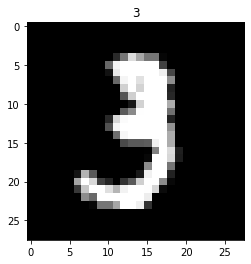

In [ ]:
plt.imshow(train_data.data[10], cmap='gray')
plt.title('%i' % train_data.targets[10])
plt.show()

In [ ]:
!mkdir MNISTtest_data

In [ ]:
from torchvision.utils import make_grid, save_image
for i in range(100):
#  plt.imshow(test_data.data[i], cmap='gray')
  # normalizing the pixel values
  save_image((test_data.data[i]/255), f"MNISTtest_data/image{i}.png")

In [ ]:
label_testdata=[]
for i in range(100):
  label_testdata.append(test_data.targets[i].numpy())

In [ ]:
label_testdataNew=[]
for i in range(100):
  label_testdataNew.append(int(label_testdata[i]))
#print(label_testdataNew)

###### Here the display of some digits in the MNIST dataset

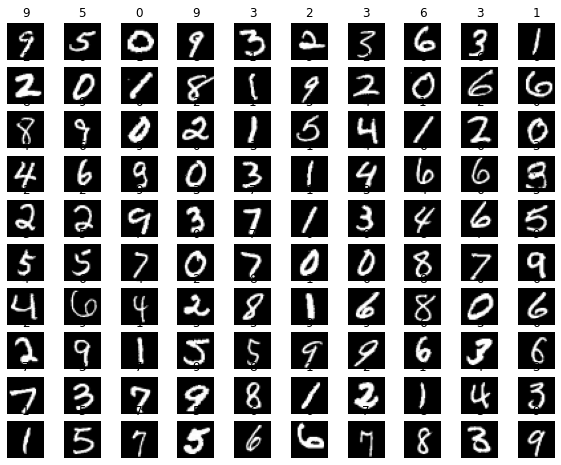

In [ ]:
figure = plt.figure(figsize=(10,8))
cols, rows =10, 10
for i in range(1, cols * rows + 1):
  sample_idx = torch.randint(len(train_data), size=(1,)).item()
  img, label = train_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(label)
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap='gray')


plt.show()

######  

*   Here the generator generates digits using a latent sample, z.
*   The attempt of the generator is to generate images such so the discriminator cannot distinguish between an image of digit present in MNIST dataset or is an image generated by the genertor

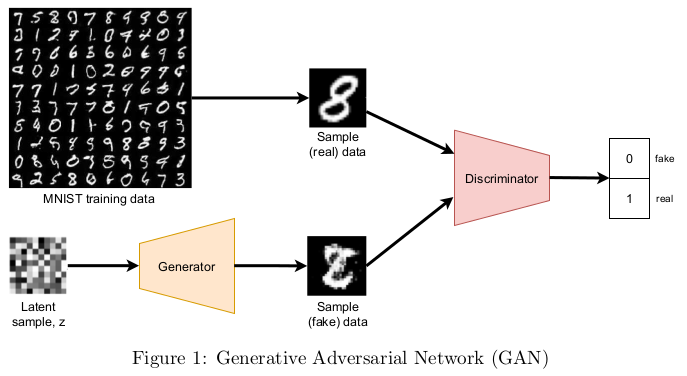

In [ ]:
class Generator(nn.Module):
    def __init__(self,gen_output_img_dim):
        super(Generator,self).__init__()
        self.layer1=nn.Sequential(
            nn.Linear(128, 1024),
            nn.LeakyReLU(0.2),
        )
        self.layer2 = nn.Sequential(
            nn.Linear(1024,1024),
            nn.LeakyReLU(0.2),
        )

        self.out = nn.Linear(1024,784)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        output = self.out(x)
        return torch.tanh(output)

In [ ]:
G = Generator(784).to(device)
print (G)

Generator(
  (layer1): Sequential(
    (0): Linear(in_features=128, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (out): Linear(in_features=1024, out_features=784, bias=True)
)


In [ ]:
import torch.nn as nn
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
        )
        self.layer2 = nn.Sequential(
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
        )

        self.out = nn.Linear(256, 1)


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        output = self.out(x)
        return torch.sigmoid(output)

In [ ]:
D = Discriminator().to(device)


In [ ]:
import torch.optim as optim

# learning_rate=0.0002
generator_optimizer = optim.Adam(G.parameters(), lr=0.0002 , betas=(0.5, 0.999))
generator_optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    eps: 1e-08
    lr: 0.0002
    weight_decay: 0
)

In [ ]:
discriminator_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
discriminator_optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    eps: 1e-08
    lr: 0.0002
    weight_decay: 0
)

In [ ]:
loss_function=nn.BCELoss()

In [ ]:
!mkdir latent_files

In [ ]:
!mkdir latent_files2

### By epoch 150 I print the generated images as a grid of 10 by 10

Epoch [1/200], Discriminator_loss 0.5394, Generator_Loss 1.6612
Epoch [1/200], Discriminator_loss 0.4332, Generator_Loss 1.6102
Epoch [1/200], Discriminator_loss 0.5037, Generator_Loss 1.6403
Epoch [1/200], Discriminator_loss 0.5296, Generator_Loss 1.1986
Epoch [1/200], Discriminator_loss 0.4389, Generator_Loss 1.1416
Epoch [1/200], Discriminator_loss 0.5398, Generator_Loss 1.1627


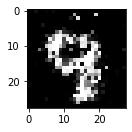

Epoch [2/200], Discriminator_loss 0.4586, Generator_Loss 1.6624
Epoch [2/200], Discriminator_loss 0.5111, Generator_Loss 1.4027
Epoch [2/200], Discriminator_loss 0.4178, Generator_Loss 1.4503
Epoch [2/200], Discriminator_loss 0.5060, Generator_Loss 1.0413
Epoch [2/200], Discriminator_loss 0.4880, Generator_Loss 1.3506
Epoch [2/200], Discriminator_loss 0.5426, Generator_Loss 1.1763


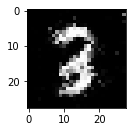

Epoch [3/200], Discriminator_loss 0.4971, Generator_Loss 1.5423
Epoch [3/200], Discriminator_loss 0.5353, Generator_Loss 1.6003
Epoch [3/200], Discriminator_loss 0.4378, Generator_Loss 1.5033
Epoch [3/200], Discriminator_loss 0.4577, Generator_Loss 1.3883
Epoch [3/200], Discriminator_loss 0.5313, Generator_Loss 1.1249
Epoch [3/200], Discriminator_loss 0.4522, Generator_Loss 1.3995


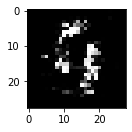

Epoch [4/200], Discriminator_loss 0.5586, Generator_Loss 1.4260
Epoch [4/200], Discriminator_loss 0.4816, Generator_Loss 1.2417
Epoch [4/200], Discriminator_loss 0.5652, Generator_Loss 1.2553
Epoch [4/200], Discriminator_loss 0.5901, Generator_Loss 1.4339
Epoch [4/200], Discriminator_loss 0.5185, Generator_Loss 1.3549
Epoch [4/200], Discriminator_loss 0.4962, Generator_Loss 1.1739


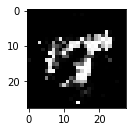

Epoch [5/200], Discriminator_loss 0.5760, Generator_Loss 0.9786
Epoch [5/200], Discriminator_loss 0.5638, Generator_Loss 1.1738
Epoch [5/200], Discriminator_loss 0.5776, Generator_Loss 1.1300
Epoch [5/200], Discriminator_loss 0.5810, Generator_Loss 1.0705
Epoch [5/200], Discriminator_loss 0.5556, Generator_Loss 1.1036
Epoch [5/200], Discriminator_loss 0.6090, Generator_Loss 1.0275


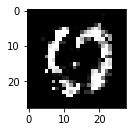

Epoch [6/200], Discriminator_loss 0.5923, Generator_Loss 0.8851
Epoch [6/200], Discriminator_loss 0.6216, Generator_Loss 1.0840
Epoch [6/200], Discriminator_loss 0.6016, Generator_Loss 0.9731
Epoch [6/200], Discriminator_loss 0.5333, Generator_Loss 1.1868
Epoch [6/200], Discriminator_loss 0.6294, Generator_Loss 0.9129
Epoch [6/200], Discriminator_loss 0.5560, Generator_Loss 1.0785


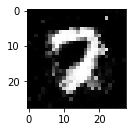

Epoch [7/200], Discriminator_loss 0.6184, Generator_Loss 0.9584
Epoch [7/200], Discriminator_loss 0.5781, Generator_Loss 0.9934
Epoch [7/200], Discriminator_loss 0.5729, Generator_Loss 0.8158
Epoch [7/200], Discriminator_loss 0.6404, Generator_Loss 0.9569
Epoch [7/200], Discriminator_loss 0.6066, Generator_Loss 0.9061
Epoch [7/200], Discriminator_loss 0.5836, Generator_Loss 0.8567


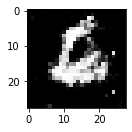

Epoch [8/200], Discriminator_loss 0.5462, Generator_Loss 0.9826
Epoch [8/200], Discriminator_loss 0.6724, Generator_Loss 0.9859
Epoch [8/200], Discriminator_loss 0.6316, Generator_Loss 0.9096
Epoch [8/200], Discriminator_loss 0.6415, Generator_Loss 0.9551
Epoch [8/200], Discriminator_loss 0.6306, Generator_Loss 0.9974
Epoch [8/200], Discriminator_loss 0.6182, Generator_Loss 0.9664


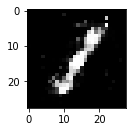

Epoch [9/200], Discriminator_loss 0.5883, Generator_Loss 0.8586
Epoch [9/200], Discriminator_loss 0.6419, Generator_Loss 0.9367
Epoch [9/200], Discriminator_loss 0.6510, Generator_Loss 0.9244
Epoch [9/200], Discriminator_loss 0.6151, Generator_Loss 0.9328
Epoch [9/200], Discriminator_loss 0.6321, Generator_Loss 1.0025
Epoch [9/200], Discriminator_loss 0.6452, Generator_Loss 0.9394


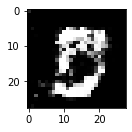

Epoch [10/200], Discriminator_loss 0.6659, Generator_Loss 0.8197
Epoch [10/200], Discriminator_loss 0.6106, Generator_Loss 0.9403
Epoch [10/200], Discriminator_loss 0.6091, Generator_Loss 0.8373
Epoch [10/200], Discriminator_loss 0.5936, Generator_Loss 0.8632
Epoch [10/200], Discriminator_loss 0.6363, Generator_Loss 0.9446
Epoch [10/200], Discriminator_loss 0.6154, Generator_Loss 0.9226


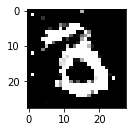

Epoch [11/200], Discriminator_loss 0.6193, Generator_Loss 0.8832
Epoch [11/200], Discriminator_loss 0.6344, Generator_Loss 0.9355
Epoch [11/200], Discriminator_loss 0.6354, Generator_Loss 0.8499
Epoch [11/200], Discriminator_loss 0.6070, Generator_Loss 0.8493
Epoch [11/200], Discriminator_loss 0.6044, Generator_Loss 0.9052
Epoch [11/200], Discriminator_loss 0.5967, Generator_Loss 0.9395


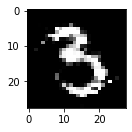

Epoch [12/200], Discriminator_loss 0.6619, Generator_Loss 0.8199
Epoch [12/200], Discriminator_loss 0.6406, Generator_Loss 0.8686
Epoch [12/200], Discriminator_loss 0.6164, Generator_Loss 0.8736
Epoch [12/200], Discriminator_loss 0.6319, Generator_Loss 0.9560
Epoch [12/200], Discriminator_loss 0.6262, Generator_Loss 0.7926
Epoch [12/200], Discriminator_loss 0.6366, Generator_Loss 0.8747


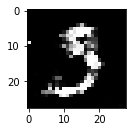

Epoch [13/200], Discriminator_loss 0.6305, Generator_Loss 0.8344
Epoch [13/200], Discriminator_loss 0.6263, Generator_Loss 0.7952
Epoch [13/200], Discriminator_loss 0.6275, Generator_Loss 0.9408
Epoch [13/200], Discriminator_loss 0.5998, Generator_Loss 0.8413
Epoch [13/200], Discriminator_loss 0.7042, Generator_Loss 0.8418
Epoch [13/200], Discriminator_loss 0.6443, Generator_Loss 0.8137


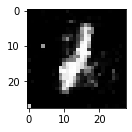

Epoch [14/200], Discriminator_loss 0.6381, Generator_Loss 0.8310
Epoch [14/200], Discriminator_loss 0.6224, Generator_Loss 0.8551
Epoch [14/200], Discriminator_loss 0.6329, Generator_Loss 0.9466
Epoch [14/200], Discriminator_loss 0.5930, Generator_Loss 0.8820
Epoch [14/200], Discriminator_loss 0.6358, Generator_Loss 0.8162
Epoch [14/200], Discriminator_loss 0.6356, Generator_Loss 0.9445


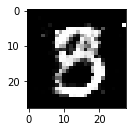

Epoch [15/200], Discriminator_loss 0.6600, Generator_Loss 0.7766
Epoch [15/200], Discriminator_loss 0.6412, Generator_Loss 0.7964
Epoch [15/200], Discriminator_loss 0.6303, Generator_Loss 0.8602
Epoch [15/200], Discriminator_loss 0.6357, Generator_Loss 0.8514
Epoch [15/200], Discriminator_loss 0.6380, Generator_Loss 0.9287
Epoch [15/200], Discriminator_loss 0.6682, Generator_Loss 0.9504


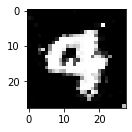

Epoch [16/200], Discriminator_loss 0.6442, Generator_Loss 0.8234
Epoch [16/200], Discriminator_loss 0.6290, Generator_Loss 0.9482
Epoch [16/200], Discriminator_loss 0.6766, Generator_Loss 0.8439
Epoch [16/200], Discriminator_loss 0.6845, Generator_Loss 0.8514
Epoch [16/200], Discriminator_loss 0.6214, Generator_Loss 0.8432
Epoch [16/200], Discriminator_loss 0.6869, Generator_Loss 0.9331


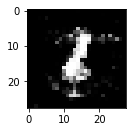

Epoch [17/200], Discriminator_loss 0.7054, Generator_Loss 0.8026
Epoch [17/200], Discriminator_loss 0.6607, Generator_Loss 0.8254
Epoch [17/200], Discriminator_loss 0.6505, Generator_Loss 0.8368
Epoch [17/200], Discriminator_loss 0.6602, Generator_Loss 0.8243
Epoch [17/200], Discriminator_loss 0.6615, Generator_Loss 0.8061
Epoch [17/200], Discriminator_loss 0.6510, Generator_Loss 0.8505


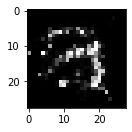

Epoch [18/200], Discriminator_loss 0.6514, Generator_Loss 0.8694
Epoch [18/200], Discriminator_loss 0.6681, Generator_Loss 0.8116
Epoch [18/200], Discriminator_loss 0.6605, Generator_Loss 0.9026
Epoch [18/200], Discriminator_loss 0.6532, Generator_Loss 0.8227
Epoch [18/200], Discriminator_loss 0.6410, Generator_Loss 0.7861
Epoch [18/200], Discriminator_loss 0.6597, Generator_Loss 0.8525


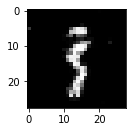

Epoch [19/200], Discriminator_loss 0.6532, Generator_Loss 0.8499
Epoch [19/200], Discriminator_loss 0.6560, Generator_Loss 0.8481
Epoch [19/200], Discriminator_loss 0.6889, Generator_Loss 0.8202
Epoch [19/200], Discriminator_loss 0.6486, Generator_Loss 0.7493
Epoch [19/200], Discriminator_loss 0.6399, Generator_Loss 0.8311
Epoch [19/200], Discriminator_loss 0.6613, Generator_Loss 0.7351


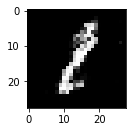

Epoch [20/200], Discriminator_loss 0.6281, Generator_Loss 0.8424
Epoch [20/200], Discriminator_loss 0.6761, Generator_Loss 0.8466
Epoch [20/200], Discriminator_loss 0.6521, Generator_Loss 0.9002
Epoch [20/200], Discriminator_loss 0.6563, Generator_Loss 0.8317
Epoch [20/200], Discriminator_loss 0.6562, Generator_Loss 0.7974
Epoch [20/200], Discriminator_loss 0.6648, Generator_Loss 0.8044


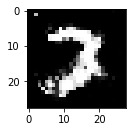

Epoch [21/200], Discriminator_loss 0.6474, Generator_Loss 0.8598
Epoch [21/200], Discriminator_loss 0.6626, Generator_Loss 0.7494
Epoch [21/200], Discriminator_loss 0.6759, Generator_Loss 0.8338
Epoch [21/200], Discriminator_loss 0.6700, Generator_Loss 0.8176
Epoch [21/200], Discriminator_loss 0.6953, Generator_Loss 0.8459
Epoch [21/200], Discriminator_loss 0.6433, Generator_Loss 0.7855


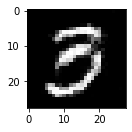

Epoch [22/200], Discriminator_loss 0.6626, Generator_Loss 0.7985
Epoch [22/200], Discriminator_loss 0.6576, Generator_Loss 0.8584
Epoch [22/200], Discriminator_loss 0.6661, Generator_Loss 0.8740
Epoch [22/200], Discriminator_loss 0.6641, Generator_Loss 0.7485
Epoch [22/200], Discriminator_loss 0.6600, Generator_Loss 0.8290
Epoch [22/200], Discriminator_loss 0.6996, Generator_Loss 0.8156


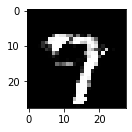

Epoch [23/200], Discriminator_loss 0.6549, Generator_Loss 0.8671
Epoch [23/200], Discriminator_loss 0.6304, Generator_Loss 0.8613
Epoch [23/200], Discriminator_loss 0.6768, Generator_Loss 0.8128
Epoch [23/200], Discriminator_loss 0.6738, Generator_Loss 0.8025
Epoch [23/200], Discriminator_loss 0.6573, Generator_Loss 0.8234
Epoch [23/200], Discriminator_loss 0.6745, Generator_Loss 0.8583


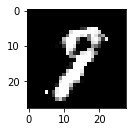

Epoch [24/200], Discriminator_loss 0.6686, Generator_Loss 0.8777
Epoch [24/200], Discriminator_loss 0.6262, Generator_Loss 0.9153
Epoch [24/200], Discriminator_loss 0.6590, Generator_Loss 0.7827
Epoch [24/200], Discriminator_loss 0.6308, Generator_Loss 0.7917
Epoch [24/200], Discriminator_loss 0.6027, Generator_Loss 0.8287
Epoch [24/200], Discriminator_loss 0.6512, Generator_Loss 0.8345


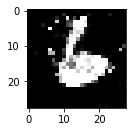

Epoch [25/200], Discriminator_loss 0.6464, Generator_Loss 0.7543
Epoch [25/200], Discriminator_loss 0.6501, Generator_Loss 0.8676
Epoch [25/200], Discriminator_loss 0.6841, Generator_Loss 0.7795
Epoch [25/200], Discriminator_loss 0.6887, Generator_Loss 0.7458
Epoch [25/200], Discriminator_loss 0.6718, Generator_Loss 0.8794
Epoch [25/200], Discriminator_loss 0.6782, Generator_Loss 0.7889


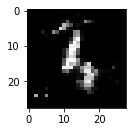

Epoch [26/200], Discriminator_loss 0.6527, Generator_Loss 0.8332
Epoch [26/200], Discriminator_loss 0.6709, Generator_Loss 0.8136
Epoch [26/200], Discriminator_loss 0.6503, Generator_Loss 0.7405
Epoch [26/200], Discriminator_loss 0.6730, Generator_Loss 0.8342
Epoch [26/200], Discriminator_loss 0.6585, Generator_Loss 0.7699
Epoch [26/200], Discriminator_loss 0.6708, Generator_Loss 0.8004


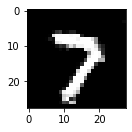

Epoch [27/200], Discriminator_loss 0.6523, Generator_Loss 0.7922
Epoch [27/200], Discriminator_loss 0.6939, Generator_Loss 0.7723
Epoch [27/200], Discriminator_loss 0.6488, Generator_Loss 0.8597
Epoch [27/200], Discriminator_loss 0.6855, Generator_Loss 0.7954
Epoch [27/200], Discriminator_loss 0.6731, Generator_Loss 0.7785
Epoch [27/200], Discriminator_loss 0.6974, Generator_Loss 0.8040


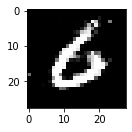

Epoch [28/200], Discriminator_loss 0.6593, Generator_Loss 0.7777
Epoch [28/200], Discriminator_loss 0.6516, Generator_Loss 0.7439
Epoch [28/200], Discriminator_loss 0.6697, Generator_Loss 0.7763
Epoch [28/200], Discriminator_loss 0.6750, Generator_Loss 0.7932
Epoch [28/200], Discriminator_loss 0.6590, Generator_Loss 0.7891
Epoch [28/200], Discriminator_loss 0.6653, Generator_Loss 0.7484


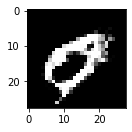

Epoch [29/200], Discriminator_loss 0.6441, Generator_Loss 0.6932
Epoch [29/200], Discriminator_loss 0.6574, Generator_Loss 0.8039
Epoch [29/200], Discriminator_loss 0.6758, Generator_Loss 0.9081
Epoch [29/200], Discriminator_loss 0.6414, Generator_Loss 0.8457
Epoch [29/200], Discriminator_loss 0.6830, Generator_Loss 0.8251
Epoch [29/200], Discriminator_loss 0.6590, Generator_Loss 0.8119


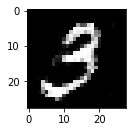

Epoch [30/200], Discriminator_loss 0.6386, Generator_Loss 0.8717
Epoch [30/200], Discriminator_loss 0.6705, Generator_Loss 0.7785
Epoch [30/200], Discriminator_loss 0.6795, Generator_Loss 0.6998
Epoch [30/200], Discriminator_loss 0.6096, Generator_Loss 0.7698
Epoch [30/200], Discriminator_loss 0.6520, Generator_Loss 0.8865
Epoch [30/200], Discriminator_loss 0.6470, Generator_Loss 0.7650


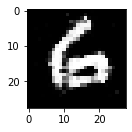

Epoch [31/200], Discriminator_loss 0.6610, Generator_Loss 0.8471
Epoch [31/200], Discriminator_loss 0.6287, Generator_Loss 0.8269
Epoch [31/200], Discriminator_loss 0.6504, Generator_Loss 0.8266
Epoch [31/200], Discriminator_loss 0.6650, Generator_Loss 0.8708
Epoch [31/200], Discriminator_loss 0.6582, Generator_Loss 0.8220
Epoch [31/200], Discriminator_loss 0.6747, Generator_Loss 0.8466


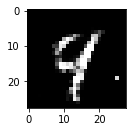

Epoch [32/200], Discriminator_loss 0.6525, Generator_Loss 0.8056
Epoch [32/200], Discriminator_loss 0.6450, Generator_Loss 0.8031
Epoch [32/200], Discriminator_loss 0.6680, Generator_Loss 0.8145
Epoch [32/200], Discriminator_loss 0.6984, Generator_Loss 0.7873
Epoch [32/200], Discriminator_loss 0.6648, Generator_Loss 0.7305
Epoch [32/200], Discriminator_loss 0.6797, Generator_Loss 0.8006


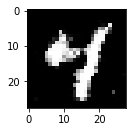

Epoch [33/200], Discriminator_loss 0.6666, Generator_Loss 0.7983
Epoch [33/200], Discriminator_loss 0.6643, Generator_Loss 0.7876
Epoch [33/200], Discriminator_loss 0.6786, Generator_Loss 0.7537
Epoch [33/200], Discriminator_loss 0.6794, Generator_Loss 0.7560
Epoch [33/200], Discriminator_loss 0.6773, Generator_Loss 0.7789
Epoch [33/200], Discriminator_loss 0.6452, Generator_Loss 0.8355


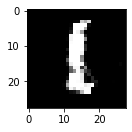

Epoch [34/200], Discriminator_loss 0.6534, Generator_Loss 0.8136
Epoch [34/200], Discriminator_loss 0.6723, Generator_Loss 0.7449
Epoch [34/200], Discriminator_loss 0.6718, Generator_Loss 0.8219
Epoch [34/200], Discriminator_loss 0.6366, Generator_Loss 0.8186
Epoch [34/200], Discriminator_loss 0.6594, Generator_Loss 0.8197
Epoch [34/200], Discriminator_loss 0.6339, Generator_Loss 0.7487


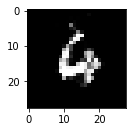

Epoch [35/200], Discriminator_loss 0.6449, Generator_Loss 0.8058
Epoch [35/200], Discriminator_loss 0.6421, Generator_Loss 0.7596
Epoch [35/200], Discriminator_loss 0.6599, Generator_Loss 0.8657
Epoch [35/200], Discriminator_loss 0.6761, Generator_Loss 0.8074
Epoch [35/200], Discriminator_loss 0.6510, Generator_Loss 0.8299
Epoch [35/200], Discriminator_loss 0.6646, Generator_Loss 0.8107


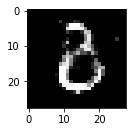

Epoch [36/200], Discriminator_loss 0.6396, Generator_Loss 0.7688
Epoch [36/200], Discriminator_loss 0.6655, Generator_Loss 0.7566
Epoch [36/200], Discriminator_loss 0.6559, Generator_Loss 0.8121
Epoch [36/200], Discriminator_loss 0.6453, Generator_Loss 0.8168
Epoch [36/200], Discriminator_loss 0.6747, Generator_Loss 0.7431
Epoch [36/200], Discriminator_loss 0.6774, Generator_Loss 0.8049


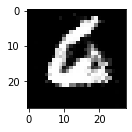

Epoch [37/200], Discriminator_loss 0.6559, Generator_Loss 0.7475
Epoch [37/200], Discriminator_loss 0.6600, Generator_Loss 0.8515
Epoch [37/200], Discriminator_loss 0.6641, Generator_Loss 0.8323
Epoch [37/200], Discriminator_loss 0.6968, Generator_Loss 0.8717
Epoch [37/200], Discriminator_loss 0.6409, Generator_Loss 0.8128
Epoch [37/200], Discriminator_loss 0.6523, Generator_Loss 0.8514


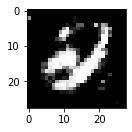

Epoch [38/200], Discriminator_loss 0.6589, Generator_Loss 0.7556
Epoch [38/200], Discriminator_loss 0.6569, Generator_Loss 0.6970
Epoch [38/200], Discriminator_loss 0.6351, Generator_Loss 0.8307
Epoch [38/200], Discriminator_loss 0.6620, Generator_Loss 0.9025
Epoch [38/200], Discriminator_loss 0.6718, Generator_Loss 0.7383
Epoch [38/200], Discriminator_loss 0.6621, Generator_Loss 0.8779


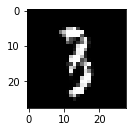

Epoch [39/200], Discriminator_loss 0.6873, Generator_Loss 0.7522
Epoch [39/200], Discriminator_loss 0.6531, Generator_Loss 0.7216
Epoch [39/200], Discriminator_loss 0.6998, Generator_Loss 0.8042
Epoch [39/200], Discriminator_loss 0.6665, Generator_Loss 0.7986
Epoch [39/200], Discriminator_loss 0.6438, Generator_Loss 0.7098
Epoch [39/200], Discriminator_loss 0.6638, Generator_Loss 0.7433


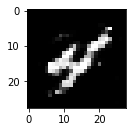

Epoch [40/200], Discriminator_loss 0.6604, Generator_Loss 0.7909
Epoch [40/200], Discriminator_loss 0.6788, Generator_Loss 0.7214
Epoch [40/200], Discriminator_loss 0.6751, Generator_Loss 0.7783
Epoch [40/200], Discriminator_loss 0.6286, Generator_Loss 0.7352
Epoch [40/200], Discriminator_loss 0.6483, Generator_Loss 0.7890
Epoch [40/200], Discriminator_loss 0.6527, Generator_Loss 0.8454


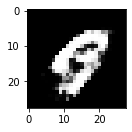

Epoch [41/200], Discriminator_loss 0.6469, Generator_Loss 0.8051
Epoch [41/200], Discriminator_loss 0.6530, Generator_Loss 0.8480
Epoch [41/200], Discriminator_loss 0.6540, Generator_Loss 0.7363
Epoch [41/200], Discriminator_loss 0.6572, Generator_Loss 0.7831
Epoch [41/200], Discriminator_loss 0.6672, Generator_Loss 0.7292
Epoch [41/200], Discriminator_loss 0.6535, Generator_Loss 0.7611


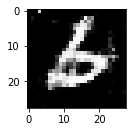

Epoch [42/200], Discriminator_loss 0.6309, Generator_Loss 0.7733
Epoch [42/200], Discriminator_loss 0.6668, Generator_Loss 0.7866
Epoch [42/200], Discriminator_loss 0.7062, Generator_Loss 0.7848
Epoch [42/200], Discriminator_loss 0.6537, Generator_Loss 0.7613
Epoch [42/200], Discriminator_loss 0.6819, Generator_Loss 0.8301
Epoch [42/200], Discriminator_loss 0.6516, Generator_Loss 0.8205


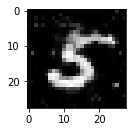

Epoch [43/200], Discriminator_loss 0.6668, Generator_Loss 0.8138
Epoch [43/200], Discriminator_loss 0.6758, Generator_Loss 0.7719
Epoch [43/200], Discriminator_loss 0.6680, Generator_Loss 0.7889
Epoch [43/200], Discriminator_loss 0.6257, Generator_Loss 0.8295
Epoch [43/200], Discriminator_loss 0.6700, Generator_Loss 0.7516
Epoch [43/200], Discriminator_loss 0.6859, Generator_Loss 0.7471


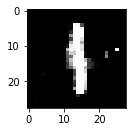

Epoch [44/200], Discriminator_loss 0.6586, Generator_Loss 0.7670
Epoch [44/200], Discriminator_loss 0.6293, Generator_Loss 0.8173
Epoch [44/200], Discriminator_loss 0.6585, Generator_Loss 0.8545
Epoch [44/200], Discriminator_loss 0.6421, Generator_Loss 0.8010
Epoch [44/200], Discriminator_loss 0.6797, Generator_Loss 0.7595
Epoch [44/200], Discriminator_loss 0.6767, Generator_Loss 0.7814


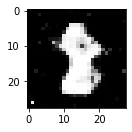

Epoch [45/200], Discriminator_loss 0.6442, Generator_Loss 0.8263
Epoch [45/200], Discriminator_loss 0.6788, Generator_Loss 0.7635
Epoch [45/200], Discriminator_loss 0.6713, Generator_Loss 0.7410
Epoch [45/200], Discriminator_loss 0.6859, Generator_Loss 0.7307
Epoch [45/200], Discriminator_loss 0.6833, Generator_Loss 0.8308
Epoch [45/200], Discriminator_loss 0.6631, Generator_Loss 0.7905


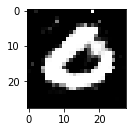

Epoch [46/200], Discriminator_loss 0.6633, Generator_Loss 0.7816
Epoch [46/200], Discriminator_loss 0.6405, Generator_Loss 0.8234
Epoch [46/200], Discriminator_loss 0.6638, Generator_Loss 0.7443
Epoch [46/200], Discriminator_loss 0.6793, Generator_Loss 0.7935
Epoch [46/200], Discriminator_loss 0.6436, Generator_Loss 0.9299
Epoch [46/200], Discriminator_loss 0.6615, Generator_Loss 0.7732


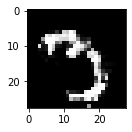

Epoch [47/200], Discriminator_loss 0.6708, Generator_Loss 0.8103
Epoch [47/200], Discriminator_loss 0.6783, Generator_Loss 0.7439
Epoch [47/200], Discriminator_loss 0.6688, Generator_Loss 0.7632
Epoch [47/200], Discriminator_loss 0.6532, Generator_Loss 0.7997
Epoch [47/200], Discriminator_loss 0.6695, Generator_Loss 0.7553
Epoch [47/200], Discriminator_loss 0.6664, Generator_Loss 0.8082


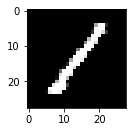

Epoch [48/200], Discriminator_loss 0.6386, Generator_Loss 0.8297
Epoch [48/200], Discriminator_loss 0.6772, Generator_Loss 0.7854
Epoch [48/200], Discriminator_loss 0.6473, Generator_Loss 0.8490
Epoch [48/200], Discriminator_loss 0.6565, Generator_Loss 0.8459
Epoch [48/200], Discriminator_loss 0.6879, Generator_Loss 0.8365
Epoch [48/200], Discriminator_loss 0.6402, Generator_Loss 0.7386


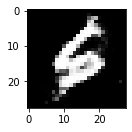

Epoch [49/200], Discriminator_loss 0.6396, Generator_Loss 0.8192
Epoch [49/200], Discriminator_loss 0.6433, Generator_Loss 0.8734
Epoch [49/200], Discriminator_loss 0.6654, Generator_Loss 0.6959
Epoch [49/200], Discriminator_loss 0.6488, Generator_Loss 0.7723
Epoch [49/200], Discriminator_loss 0.6630, Generator_Loss 0.8069
Epoch [49/200], Discriminator_loss 0.6774, Generator_Loss 0.7460


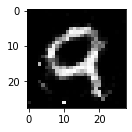

Epoch [50/200], Discriminator_loss 0.6409, Generator_Loss 0.8480
Epoch [50/200], Discriminator_loss 0.6792, Generator_Loss 0.9027
Epoch [50/200], Discriminator_loss 0.6703, Generator_Loss 0.7829
Epoch [50/200], Discriminator_loss 0.6681, Generator_Loss 0.8573
Epoch [50/200], Discriminator_loss 0.6752, Generator_Loss 0.7900
Epoch [50/200], Discriminator_loss 0.6731, Generator_Loss 0.8389


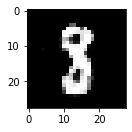

Epoch [51/200], Discriminator_loss 0.6933, Generator_Loss 0.8120
Epoch [51/200], Discriminator_loss 0.6431, Generator_Loss 0.8247
Epoch [51/200], Discriminator_loss 0.6523, Generator_Loss 0.8479
Epoch [51/200], Discriminator_loss 0.6769, Generator_Loss 0.7982
Epoch [51/200], Discriminator_loss 0.6875, Generator_Loss 0.7554
Epoch [51/200], Discriminator_loss 0.6801, Generator_Loss 0.8138


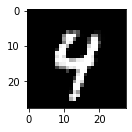

Epoch [52/200], Discriminator_loss 0.6547, Generator_Loss 0.7268
Epoch [52/200], Discriminator_loss 0.6516, Generator_Loss 0.7162
Epoch [52/200], Discriminator_loss 0.6633, Generator_Loss 0.7943
Epoch [52/200], Discriminator_loss 0.6515, Generator_Loss 0.7377
Epoch [52/200], Discriminator_loss 0.6655, Generator_Loss 0.7796
Epoch [52/200], Discriminator_loss 0.6632, Generator_Loss 0.7806


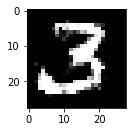

Epoch [53/200], Discriminator_loss 0.6624, Generator_Loss 0.7481
Epoch [53/200], Discriminator_loss 0.6775, Generator_Loss 0.8096
Epoch [53/200], Discriminator_loss 0.6769, Generator_Loss 0.8483
Epoch [53/200], Discriminator_loss 0.6742, Generator_Loss 0.7816
Epoch [53/200], Discriminator_loss 0.6425, Generator_Loss 0.8114
Epoch [53/200], Discriminator_loss 0.6592, Generator_Loss 0.8091


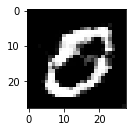

Epoch [54/200], Discriminator_loss 0.6365, Generator_Loss 0.8185
Epoch [54/200], Discriminator_loss 0.6840, Generator_Loss 0.7843
Epoch [54/200], Discriminator_loss 0.6663, Generator_Loss 0.7749
Epoch [54/200], Discriminator_loss 0.6750, Generator_Loss 0.7675
Epoch [54/200], Discriminator_loss 0.6768, Generator_Loss 0.7567
Epoch [54/200], Discriminator_loss 0.6301, Generator_Loss 0.8647


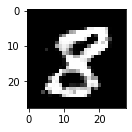

Epoch [55/200], Discriminator_loss 0.6593, Generator_Loss 0.7686
Epoch [55/200], Discriminator_loss 0.6759, Generator_Loss 0.8394
Epoch [55/200], Discriminator_loss 0.6613, Generator_Loss 0.8324
Epoch [55/200], Discriminator_loss 0.6726, Generator_Loss 0.8320
Epoch [55/200], Discriminator_loss 0.6521, Generator_Loss 0.7339
Epoch [55/200], Discriminator_loss 0.6675, Generator_Loss 0.7675


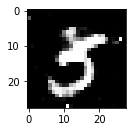

Epoch [56/200], Discriminator_loss 0.6668, Generator_Loss 0.8036
Epoch [56/200], Discriminator_loss 0.6751, Generator_Loss 0.8862
Epoch [56/200], Discriminator_loss 0.6425, Generator_Loss 0.8360
Epoch [56/200], Discriminator_loss 0.6255, Generator_Loss 0.7869
Epoch [56/200], Discriminator_loss 0.6549, Generator_Loss 0.8701
Epoch [56/200], Discriminator_loss 0.6614, Generator_Loss 0.7517


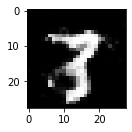

Epoch [57/200], Discriminator_loss 0.6512, Generator_Loss 0.7635
Epoch [57/200], Discriminator_loss 0.6825, Generator_Loss 0.8406
Epoch [57/200], Discriminator_loss 0.6506, Generator_Loss 0.7870
Epoch [57/200], Discriminator_loss 0.6684, Generator_Loss 0.8057
Epoch [57/200], Discriminator_loss 0.6580, Generator_Loss 0.7811
Epoch [57/200], Discriminator_loss 0.6642, Generator_Loss 0.7928


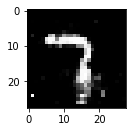

Epoch [58/200], Discriminator_loss 0.6634, Generator_Loss 0.8035
Epoch [58/200], Discriminator_loss 0.6460, Generator_Loss 0.8441
Epoch [58/200], Discriminator_loss 0.6624, Generator_Loss 0.7971
Epoch [58/200], Discriminator_loss 0.6579, Generator_Loss 0.8042
Epoch [58/200], Discriminator_loss 0.6656, Generator_Loss 0.8048
Epoch [58/200], Discriminator_loss 0.6622, Generator_Loss 0.7622


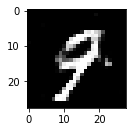

Epoch [59/200], Discriminator_loss 0.6375, Generator_Loss 0.7827
Epoch [59/200], Discriminator_loss 0.6701, Generator_Loss 0.7937
Epoch [59/200], Discriminator_loss 0.6887, Generator_Loss 0.8111
Epoch [59/200], Discriminator_loss 0.6679, Generator_Loss 0.7913
Epoch [59/200], Discriminator_loss 0.6393, Generator_Loss 0.7124
Epoch [59/200], Discriminator_loss 0.6588, Generator_Loss 0.7984


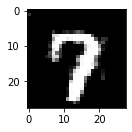

Epoch [60/200], Discriminator_loss 0.6682, Generator_Loss 0.7617
Epoch [60/200], Discriminator_loss 0.6766, Generator_Loss 0.7978
Epoch [60/200], Discriminator_loss 0.6412, Generator_Loss 0.8132
Epoch [60/200], Discriminator_loss 0.6233, Generator_Loss 0.8312
Epoch [60/200], Discriminator_loss 0.6870, Generator_Loss 0.8303
Epoch [60/200], Discriminator_loss 0.6617, Generator_Loss 0.7613


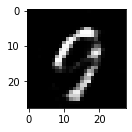

Epoch [61/200], Discriminator_loss 0.6330, Generator_Loss 0.9140
Epoch [61/200], Discriminator_loss 0.6573, Generator_Loss 0.7244
Epoch [61/200], Discriminator_loss 0.6728, Generator_Loss 0.8112
Epoch [61/200], Discriminator_loss 0.6791, Generator_Loss 0.7954
Epoch [61/200], Discriminator_loss 0.6687, Generator_Loss 0.8310
Epoch [61/200], Discriminator_loss 0.6629, Generator_Loss 0.7728


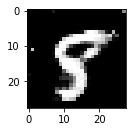

Epoch [62/200], Discriminator_loss 0.6739, Generator_Loss 0.8253
Epoch [62/200], Discriminator_loss 0.6671, Generator_Loss 0.7798
Epoch [62/200], Discriminator_loss 0.6555, Generator_Loss 0.7869
Epoch [62/200], Discriminator_loss 0.6804, Generator_Loss 0.8178
Epoch [62/200], Discriminator_loss 0.6644, Generator_Loss 0.8353
Epoch [62/200], Discriminator_loss 0.6632, Generator_Loss 0.7461


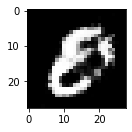

Epoch [63/200], Discriminator_loss 0.6353, Generator_Loss 0.7915
Epoch [63/200], Discriminator_loss 0.6580, Generator_Loss 0.8525
Epoch [63/200], Discriminator_loss 0.6475, Generator_Loss 0.8028
Epoch [63/200], Discriminator_loss 0.6591, Generator_Loss 0.7820
Epoch [63/200], Discriminator_loss 0.6231, Generator_Loss 0.9202
Epoch [63/200], Discriminator_loss 0.6518, Generator_Loss 0.7931


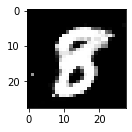

Epoch [64/200], Discriminator_loss 0.6837, Generator_Loss 0.8439
Epoch [64/200], Discriminator_loss 0.6814, Generator_Loss 0.7920
Epoch [64/200], Discriminator_loss 0.6393, Generator_Loss 0.8177
Epoch [64/200], Discriminator_loss 0.6772, Generator_Loss 0.8379
Epoch [64/200], Discriminator_loss 0.6454, Generator_Loss 0.8626
Epoch [64/200], Discriminator_loss 0.6960, Generator_Loss 0.7647


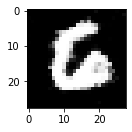

Epoch [65/200], Discriminator_loss 0.6618, Generator_Loss 0.8095
Epoch [65/200], Discriminator_loss 0.6967, Generator_Loss 0.8228
Epoch [65/200], Discriminator_loss 0.6564, Generator_Loss 0.8475
Epoch [65/200], Discriminator_loss 0.6597, Generator_Loss 0.8288
Epoch [65/200], Discriminator_loss 0.6469, Generator_Loss 0.7319
Epoch [65/200], Discriminator_loss 0.6090, Generator_Loss 0.8067


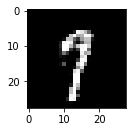

Epoch [66/200], Discriminator_loss 0.6538, Generator_Loss 0.7323
Epoch [66/200], Discriminator_loss 0.6734, Generator_Loss 0.8259
Epoch [66/200], Discriminator_loss 0.6771, Generator_Loss 0.8544
Epoch [66/200], Discriminator_loss 0.6538, Generator_Loss 0.8396
Epoch [66/200], Discriminator_loss 0.6430, Generator_Loss 0.7906
Epoch [66/200], Discriminator_loss 0.6639, Generator_Loss 0.7735


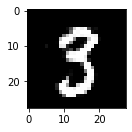

Epoch [67/200], Discriminator_loss 0.6677, Generator_Loss 0.7556
Epoch [67/200], Discriminator_loss 0.6711, Generator_Loss 0.8642
Epoch [67/200], Discriminator_loss 0.6813, Generator_Loss 0.7929
Epoch [67/200], Discriminator_loss 0.6507, Generator_Loss 0.8298
Epoch [67/200], Discriminator_loss 0.6548, Generator_Loss 0.8269
Epoch [67/200], Discriminator_loss 0.6809, Generator_Loss 0.7534


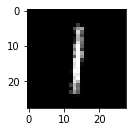

Epoch [68/200], Discriminator_loss 0.6481, Generator_Loss 0.8204
Epoch [68/200], Discriminator_loss 0.6523, Generator_Loss 0.8294
Epoch [68/200], Discriminator_loss 0.6473, Generator_Loss 0.8107
Epoch [68/200], Discriminator_loss 0.6717, Generator_Loss 0.7537
Epoch [68/200], Discriminator_loss 0.6824, Generator_Loss 0.7969
Epoch [68/200], Discriminator_loss 0.6602, Generator_Loss 0.8499


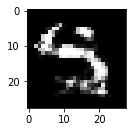

Epoch [69/200], Discriminator_loss 0.6628, Generator_Loss 0.8103
Epoch [69/200], Discriminator_loss 0.6883, Generator_Loss 0.7917
Epoch [69/200], Discriminator_loss 0.6540, Generator_Loss 0.7773
Epoch [69/200], Discriminator_loss 0.6552, Generator_Loss 0.8032
Epoch [69/200], Discriminator_loss 0.6183, Generator_Loss 0.6957
Epoch [69/200], Discriminator_loss 0.6584, Generator_Loss 0.8750


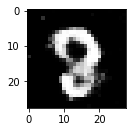

Epoch [70/200], Discriminator_loss 0.6779, Generator_Loss 0.7835
Epoch [70/200], Discriminator_loss 0.6754, Generator_Loss 0.8402
Epoch [70/200], Discriminator_loss 0.6898, Generator_Loss 0.7591
Epoch [70/200], Discriminator_loss 0.6575, Generator_Loss 0.8202
Epoch [70/200], Discriminator_loss 0.6737, Generator_Loss 0.8574
Epoch [70/200], Discriminator_loss 0.6682, Generator_Loss 0.8588


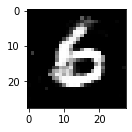

Epoch [71/200], Discriminator_loss 0.6329, Generator_Loss 0.7592
Epoch [71/200], Discriminator_loss 0.6461, Generator_Loss 0.7570
Epoch [71/200], Discriminator_loss 0.6430, Generator_Loss 0.7988
Epoch [71/200], Discriminator_loss 0.6535, Generator_Loss 0.8220
Epoch [71/200], Discriminator_loss 0.6413, Generator_Loss 0.8799
Epoch [71/200], Discriminator_loss 0.6617, Generator_Loss 0.7919


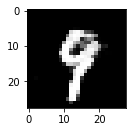

Epoch [72/200], Discriminator_loss 0.6860, Generator_Loss 0.7932
Epoch [72/200], Discriminator_loss 0.6525, Generator_Loss 0.7904
Epoch [72/200], Discriminator_loss 0.6920, Generator_Loss 0.7641
Epoch [72/200], Discriminator_loss 0.6710, Generator_Loss 0.8631
Epoch [72/200], Discriminator_loss 0.6605, Generator_Loss 0.8222
Epoch [72/200], Discriminator_loss 0.6522, Generator_Loss 0.7705


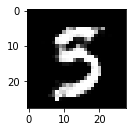

Epoch [73/200], Discriminator_loss 0.6505, Generator_Loss 0.8927
Epoch [73/200], Discriminator_loss 0.6692, Generator_Loss 0.8334
Epoch [73/200], Discriminator_loss 0.6841, Generator_Loss 0.8089
Epoch [73/200], Discriminator_loss 0.6449, Generator_Loss 0.9444
Epoch [73/200], Discriminator_loss 0.6224, Generator_Loss 0.7675
Epoch [73/200], Discriminator_loss 0.6465, Generator_Loss 0.7661


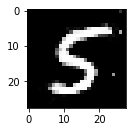

Epoch [74/200], Discriminator_loss 0.6579, Generator_Loss 0.7815
Epoch [74/200], Discriminator_loss 0.6807, Generator_Loss 0.9164
Epoch [74/200], Discriminator_loss 0.6668, Generator_Loss 0.7923
Epoch [74/200], Discriminator_loss 0.6453, Generator_Loss 0.7612
Epoch [74/200], Discriminator_loss 0.6797, Generator_Loss 0.7968
Epoch [74/200], Discriminator_loss 0.6843, Generator_Loss 0.7965


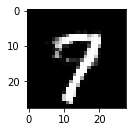

Epoch [75/200], Discriminator_loss 0.6625, Generator_Loss 0.8065
Epoch [75/200], Discriminator_loss 0.6499, Generator_Loss 0.8404
Epoch [75/200], Discriminator_loss 0.6714, Generator_Loss 0.7635
Epoch [75/200], Discriminator_loss 0.6651, Generator_Loss 0.7712
Epoch [75/200], Discriminator_loss 0.6721, Generator_Loss 0.8161
Epoch [75/200], Discriminator_loss 0.6595, Generator_Loss 0.7813


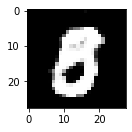

Epoch [76/200], Discriminator_loss 0.6630, Generator_Loss 0.7711
Epoch [76/200], Discriminator_loss 0.6668, Generator_Loss 0.8375
Epoch [76/200], Discriminator_loss 0.6729, Generator_Loss 0.8241
Epoch [76/200], Discriminator_loss 0.6551, Generator_Loss 0.8018
Epoch [76/200], Discriminator_loss 0.6646, Generator_Loss 0.6942
Epoch [76/200], Discriminator_loss 0.6832, Generator_Loss 0.8248


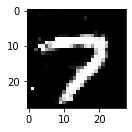

Epoch [77/200], Discriminator_loss 0.6550, Generator_Loss 0.7933
Epoch [77/200], Discriminator_loss 0.6623, Generator_Loss 0.7803
Epoch [77/200], Discriminator_loss 0.6628, Generator_Loss 0.7994
Epoch [77/200], Discriminator_loss 0.6550, Generator_Loss 0.8385
Epoch [77/200], Discriminator_loss 0.6590, Generator_Loss 0.8107
Epoch [77/200], Discriminator_loss 0.6762, Generator_Loss 0.7970


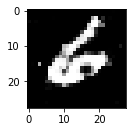

Epoch [78/200], Discriminator_loss 0.6448, Generator_Loss 0.8070
Epoch [78/200], Discriminator_loss 0.6752, Generator_Loss 0.8217
Epoch [78/200], Discriminator_loss 0.6623, Generator_Loss 0.8024
Epoch [78/200], Discriminator_loss 0.6751, Generator_Loss 0.8717
Epoch [78/200], Discriminator_loss 0.6804, Generator_Loss 0.8166
Epoch [78/200], Discriminator_loss 0.6696, Generator_Loss 0.7170


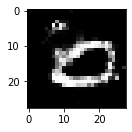

Epoch [79/200], Discriminator_loss 0.6599, Generator_Loss 0.7658
Epoch [79/200], Discriminator_loss 0.6510, Generator_Loss 0.7409
Epoch [79/200], Discriminator_loss 0.6672, Generator_Loss 0.6832
Epoch [79/200], Discriminator_loss 0.6494, Generator_Loss 0.8061
Epoch [79/200], Discriminator_loss 0.6859, Generator_Loss 0.7895
Epoch [79/200], Discriminator_loss 0.6563, Generator_Loss 0.8465


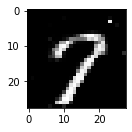

Epoch [80/200], Discriminator_loss 0.6665, Generator_Loss 0.8495
Epoch [80/200], Discriminator_loss 0.6928, Generator_Loss 0.8181
Epoch [80/200], Discriminator_loss 0.6995, Generator_Loss 0.8243
Epoch [80/200], Discriminator_loss 0.6509, Generator_Loss 0.8588
Epoch [80/200], Discriminator_loss 0.6679, Generator_Loss 0.8836
Epoch [80/200], Discriminator_loss 0.6741, Generator_Loss 0.7950


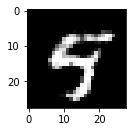

Epoch [81/200], Discriminator_loss 0.6594, Generator_Loss 0.8125
Epoch [81/200], Discriminator_loss 0.6740, Generator_Loss 0.8059
Epoch [81/200], Discriminator_loss 0.6481, Generator_Loss 0.8377
Epoch [81/200], Discriminator_loss 0.6501, Generator_Loss 0.8233
Epoch [81/200], Discriminator_loss 0.6770, Generator_Loss 0.7136
Epoch [81/200], Discriminator_loss 0.6676, Generator_Loss 0.7481


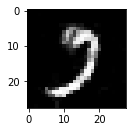

Epoch [82/200], Discriminator_loss 0.6795, Generator_Loss 0.8479
Epoch [82/200], Discriminator_loss 0.6488, Generator_Loss 0.8591
Epoch [82/200], Discriminator_loss 0.6656, Generator_Loss 0.8090
Epoch [82/200], Discriminator_loss 0.6814, Generator_Loss 0.7673
Epoch [82/200], Discriminator_loss 0.6604, Generator_Loss 0.7328
Epoch [82/200], Discriminator_loss 0.6445, Generator_Loss 0.7511


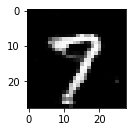

Epoch [83/200], Discriminator_loss 0.6775, Generator_Loss 0.7859
Epoch [83/200], Discriminator_loss 0.6730, Generator_Loss 0.7611
Epoch [83/200], Discriminator_loss 0.6751, Generator_Loss 0.8453
Epoch [83/200], Discriminator_loss 0.6564, Generator_Loss 0.8864
Epoch [83/200], Discriminator_loss 0.6556, Generator_Loss 0.7482
Epoch [83/200], Discriminator_loss 0.6710, Generator_Loss 0.8035


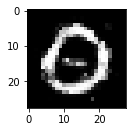

Epoch [84/200], Discriminator_loss 0.6499, Generator_Loss 0.7695
Epoch [84/200], Discriminator_loss 0.6690, Generator_Loss 0.8192
Epoch [84/200], Discriminator_loss 0.6582, Generator_Loss 0.7846
Epoch [84/200], Discriminator_loss 0.6444, Generator_Loss 0.8057
Epoch [84/200], Discriminator_loss 0.6810, Generator_Loss 0.7853
Epoch [84/200], Discriminator_loss 0.6586, Generator_Loss 0.8122


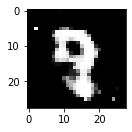

Epoch [85/200], Discriminator_loss 0.6552, Generator_Loss 0.7823
Epoch [85/200], Discriminator_loss 0.6478, Generator_Loss 0.7998
Epoch [85/200], Discriminator_loss 0.6383, Generator_Loss 0.7738
Epoch [85/200], Discriminator_loss 0.6756, Generator_Loss 0.8953
Epoch [85/200], Discriminator_loss 0.6699, Generator_Loss 0.7398
Epoch [85/200], Discriminator_loss 0.6583, Generator_Loss 0.8320


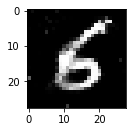

Epoch [86/200], Discriminator_loss 0.6528, Generator_Loss 0.8055
Epoch [86/200], Discriminator_loss 0.6631, Generator_Loss 0.7936
Epoch [86/200], Discriminator_loss 0.6178, Generator_Loss 0.8079
Epoch [86/200], Discriminator_loss 0.6612, Generator_Loss 0.8437
Epoch [86/200], Discriminator_loss 0.6594, Generator_Loss 0.8677
Epoch [86/200], Discriminator_loss 0.6330, Generator_Loss 0.7740


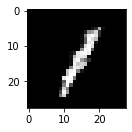

Epoch [87/200], Discriminator_loss 0.6515, Generator_Loss 0.7849
Epoch [87/200], Discriminator_loss 0.6668, Generator_Loss 0.7804
Epoch [87/200], Discriminator_loss 0.6557, Generator_Loss 0.8171
Epoch [87/200], Discriminator_loss 0.6526, Generator_Loss 0.8124
Epoch [87/200], Discriminator_loss 0.6360, Generator_Loss 0.7860
Epoch [87/200], Discriminator_loss 0.6785, Generator_Loss 0.7332


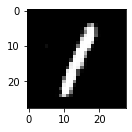

Epoch [88/200], Discriminator_loss 0.6829, Generator_Loss 0.7990
Epoch [88/200], Discriminator_loss 0.7053, Generator_Loss 0.7526
Epoch [88/200], Discriminator_loss 0.6655, Generator_Loss 0.7365
Epoch [88/200], Discriminator_loss 0.6545, Generator_Loss 0.7852
Epoch [88/200], Discriminator_loss 0.6867, Generator_Loss 0.8717
Epoch [88/200], Discriminator_loss 0.6767, Generator_Loss 0.7920


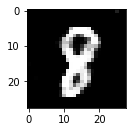

Epoch [89/200], Discriminator_loss 0.6428, Generator_Loss 0.8824
Epoch [89/200], Discriminator_loss 0.6897, Generator_Loss 0.7513
Epoch [89/200], Discriminator_loss 0.6546, Generator_Loss 0.7961
Epoch [89/200], Discriminator_loss 0.6306, Generator_Loss 0.8069
Epoch [89/200], Discriminator_loss 0.6632, Generator_Loss 0.8236
Epoch [89/200], Discriminator_loss 0.6763, Generator_Loss 0.8533


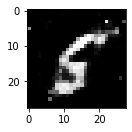

Epoch [90/200], Discriminator_loss 0.6522, Generator_Loss 0.7941
Epoch [90/200], Discriminator_loss 0.6525, Generator_Loss 0.7585
Epoch [90/200], Discriminator_loss 0.6411, Generator_Loss 0.7497
Epoch [90/200], Discriminator_loss 0.6622, Generator_Loss 0.7950
Epoch [90/200], Discriminator_loss 0.6794, Generator_Loss 0.7700
Epoch [90/200], Discriminator_loss 0.6297, Generator_Loss 0.8089


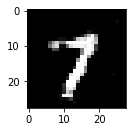

Epoch [91/200], Discriminator_loss 0.6806, Generator_Loss 0.8099
Epoch [91/200], Discriminator_loss 0.6712, Generator_Loss 0.8155
Epoch [91/200], Discriminator_loss 0.6467, Generator_Loss 0.8096
Epoch [91/200], Discriminator_loss 0.6935, Generator_Loss 0.7858
Epoch [91/200], Discriminator_loss 0.6637, Generator_Loss 0.7626
Epoch [91/200], Discriminator_loss 0.6795, Generator_Loss 0.7730


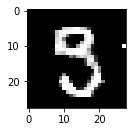

Epoch [92/200], Discriminator_loss 0.6714, Generator_Loss 0.7585
Epoch [92/200], Discriminator_loss 0.6615, Generator_Loss 0.8078
Epoch [92/200], Discriminator_loss 0.6472, Generator_Loss 0.8087
Epoch [92/200], Discriminator_loss 0.6404, Generator_Loss 0.8356
Epoch [92/200], Discriminator_loss 0.6884, Generator_Loss 0.7677
Epoch [92/200], Discriminator_loss 0.6754, Generator_Loss 0.7814


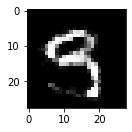

Epoch [93/200], Discriminator_loss 0.6774, Generator_Loss 0.8203
Epoch [93/200], Discriminator_loss 0.6768, Generator_Loss 0.7430
Epoch [93/200], Discriminator_loss 0.6387, Generator_Loss 0.8362
Epoch [93/200], Discriminator_loss 0.6680, Generator_Loss 0.8270
Epoch [93/200], Discriminator_loss 0.6567, Generator_Loss 0.7831
Epoch [93/200], Discriminator_loss 0.6680, Generator_Loss 0.7539


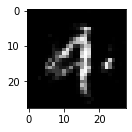

Epoch [94/200], Discriminator_loss 0.6966, Generator_Loss 0.8066
Epoch [94/200], Discriminator_loss 0.6694, Generator_Loss 0.8465
Epoch [94/200], Discriminator_loss 0.6624, Generator_Loss 0.8217
Epoch [94/200], Discriminator_loss 0.6539, Generator_Loss 0.7450
Epoch [94/200], Discriminator_loss 0.6497, Generator_Loss 0.7994
Epoch [94/200], Discriminator_loss 0.6509, Generator_Loss 0.8227


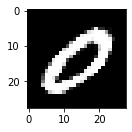

Epoch [95/200], Discriminator_loss 0.6637, Generator_Loss 0.8255
Epoch [95/200], Discriminator_loss 0.6507, Generator_Loss 0.7535
Epoch [95/200], Discriminator_loss 0.6527, Generator_Loss 0.8372
Epoch [95/200], Discriminator_loss 0.6533, Generator_Loss 0.7800
Epoch [95/200], Discriminator_loss 0.7093, Generator_Loss 0.7412
Epoch [95/200], Discriminator_loss 0.6834, Generator_Loss 0.7691


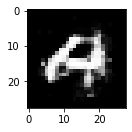

Epoch [96/200], Discriminator_loss 0.6875, Generator_Loss 0.8214
Epoch [96/200], Discriminator_loss 0.6666, Generator_Loss 0.8042
Epoch [96/200], Discriminator_loss 0.6651, Generator_Loss 0.8528
Epoch [96/200], Discriminator_loss 0.6357, Generator_Loss 0.7640
Epoch [96/200], Discriminator_loss 0.6529, Generator_Loss 0.8291
Epoch [96/200], Discriminator_loss 0.6631, Generator_Loss 0.8059


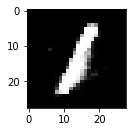

Epoch [97/200], Discriminator_loss 0.6254, Generator_Loss 0.8608
Epoch [97/200], Discriminator_loss 0.6519, Generator_Loss 0.7811
Epoch [97/200], Discriminator_loss 0.6598, Generator_Loss 0.7491
Epoch [97/200], Discriminator_loss 0.6622, Generator_Loss 0.7936
Epoch [97/200], Discriminator_loss 0.6963, Generator_Loss 0.8367
Epoch [97/200], Discriminator_loss 0.6508, Generator_Loss 0.7603


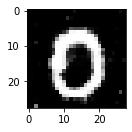

Epoch [98/200], Discriminator_loss 0.6967, Generator_Loss 0.8693
Epoch [98/200], Discriminator_loss 0.7062, Generator_Loss 0.7795
Epoch [98/200], Discriminator_loss 0.6579, Generator_Loss 0.7612
Epoch [98/200], Discriminator_loss 0.6804, Generator_Loss 0.8181
Epoch [98/200], Discriminator_loss 0.6774, Generator_Loss 0.8059
Epoch [98/200], Discriminator_loss 0.6707, Generator_Loss 0.7366


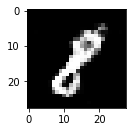

Epoch [99/200], Discriminator_loss 0.6577, Generator_Loss 0.7609
Epoch [99/200], Discriminator_loss 0.6617, Generator_Loss 0.7913
Epoch [99/200], Discriminator_loss 0.6834, Generator_Loss 0.7207
Epoch [99/200], Discriminator_loss 0.6765, Generator_Loss 0.7479
Epoch [99/200], Discriminator_loss 0.6408, Generator_Loss 0.7361
Epoch [99/200], Discriminator_loss 0.6620, Generator_Loss 0.8002


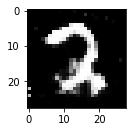

Epoch [100/200], Discriminator_loss 0.6644, Generator_Loss 0.8018
Epoch [100/200], Discriminator_loss 0.6470, Generator_Loss 0.7996
Epoch [100/200], Discriminator_loss 0.6583, Generator_Loss 0.7919
Epoch [100/200], Discriminator_loss 0.6490, Generator_Loss 0.8027
Epoch [100/200], Discriminator_loss 0.6515, Generator_Loss 0.8207
Epoch [100/200], Discriminator_loss 0.6518, Generator_Loss 0.8448


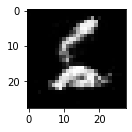

Epoch [101/200], Discriminator_loss 0.6787, Generator_Loss 0.7749
Epoch [101/200], Discriminator_loss 0.6470, Generator_Loss 0.8134
Epoch [101/200], Discriminator_loss 0.6690, Generator_Loss 0.8293
Epoch [101/200], Discriminator_loss 0.6933, Generator_Loss 0.8074
Epoch [101/200], Discriminator_loss 0.6968, Generator_Loss 0.8295
Epoch [101/200], Discriminator_loss 0.6819, Generator_Loss 0.7858


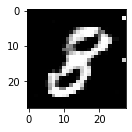

Epoch [102/200], Discriminator_loss 0.6696, Generator_Loss 0.7869
Epoch [102/200], Discriminator_loss 0.6378, Generator_Loss 0.8082
Epoch [102/200], Discriminator_loss 0.6414, Generator_Loss 0.7327
Epoch [102/200], Discriminator_loss 0.6976, Generator_Loss 0.7749
Epoch [102/200], Discriminator_loss 0.6758, Generator_Loss 0.7754
Epoch [102/200], Discriminator_loss 0.6748, Generator_Loss 0.7624


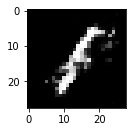

Epoch [103/200], Discriminator_loss 0.6579, Generator_Loss 0.8157
Epoch [103/200], Discriminator_loss 0.6567, Generator_Loss 0.7413
Epoch [103/200], Discriminator_loss 0.6622, Generator_Loss 0.8183
Epoch [103/200], Discriminator_loss 0.6684, Generator_Loss 0.7526
Epoch [103/200], Discriminator_loss 0.6629, Generator_Loss 0.7662
Epoch [103/200], Discriminator_loss 0.6844, Generator_Loss 0.7172


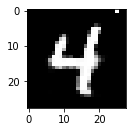

Epoch [104/200], Discriminator_loss 0.6730, Generator_Loss 0.7914
Epoch [104/200], Discriminator_loss 0.6737, Generator_Loss 0.7718
Epoch [104/200], Discriminator_loss 0.6348, Generator_Loss 0.8240
Epoch [104/200], Discriminator_loss 0.6589, Generator_Loss 0.8374
Epoch [104/200], Discriminator_loss 0.7117, Generator_Loss 0.7800
Epoch [104/200], Discriminator_loss 0.6682, Generator_Loss 0.7471


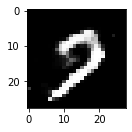

Epoch [105/200], Discriminator_loss 0.6703, Generator_Loss 0.7554
Epoch [105/200], Discriminator_loss 0.6807, Generator_Loss 0.6873
Epoch [105/200], Discriminator_loss 0.6902, Generator_Loss 0.8226
Epoch [105/200], Discriminator_loss 0.6602, Generator_Loss 0.7650
Epoch [105/200], Discriminator_loss 0.7118, Generator_Loss 0.9073
Epoch [105/200], Discriminator_loss 0.6709, Generator_Loss 0.8689


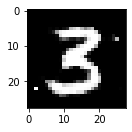

Epoch [106/200], Discriminator_loss 0.6489, Generator_Loss 0.8461
Epoch [106/200], Discriminator_loss 0.6637, Generator_Loss 0.8050
Epoch [106/200], Discriminator_loss 0.6773, Generator_Loss 0.7847
Epoch [106/200], Discriminator_loss 0.6548, Generator_Loss 0.8142
Epoch [106/200], Discriminator_loss 0.6645, Generator_Loss 0.7930
Epoch [106/200], Discriminator_loss 0.6720, Generator_Loss 0.7954


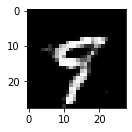

Epoch [107/200], Discriminator_loss 0.6370, Generator_Loss 0.7498
Epoch [107/200], Discriminator_loss 0.6753, Generator_Loss 0.7534
Epoch [107/200], Discriminator_loss 0.6876, Generator_Loss 0.7673
Epoch [107/200], Discriminator_loss 0.6947, Generator_Loss 0.8172
Epoch [107/200], Discriminator_loss 0.6589, Generator_Loss 0.7293
Epoch [107/200], Discriminator_loss 0.6353, Generator_Loss 0.7830


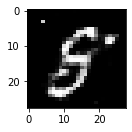

Epoch [108/200], Discriminator_loss 0.6573, Generator_Loss 0.8376
Epoch [108/200], Discriminator_loss 0.6609, Generator_Loss 0.7269
Epoch [108/200], Discriminator_loss 0.6558, Generator_Loss 0.8375
Epoch [108/200], Discriminator_loss 0.6676, Generator_Loss 0.7848
Epoch [108/200], Discriminator_loss 0.6551, Generator_Loss 0.7166
Epoch [108/200], Discriminator_loss 0.6586, Generator_Loss 0.8432


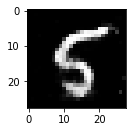

Epoch [109/200], Discriminator_loss 0.6713, Generator_Loss 0.8307
Epoch [109/200], Discriminator_loss 0.6896, Generator_Loss 0.8376
Epoch [109/200], Discriminator_loss 0.6684, Generator_Loss 0.7479
Epoch [109/200], Discriminator_loss 0.6511, Generator_Loss 0.7692
Epoch [109/200], Discriminator_loss 0.6481, Generator_Loss 0.8381
Epoch [109/200], Discriminator_loss 0.6965, Generator_Loss 0.7936


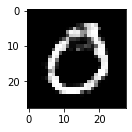

Epoch [110/200], Discriminator_loss 0.6747, Generator_Loss 0.7660
Epoch [110/200], Discriminator_loss 0.6914, Generator_Loss 0.8375
Epoch [110/200], Discriminator_loss 0.6619, Generator_Loss 0.8247
Epoch [110/200], Discriminator_loss 0.6480, Generator_Loss 0.8541
Epoch [110/200], Discriminator_loss 0.6607, Generator_Loss 0.8043
Epoch [110/200], Discriminator_loss 0.6678, Generator_Loss 0.7762


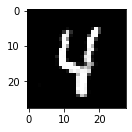

Epoch [111/200], Discriminator_loss 0.6787, Generator_Loss 0.7983
Epoch [111/200], Discriminator_loss 0.6867, Generator_Loss 0.7747
Epoch [111/200], Discriminator_loss 0.6715, Generator_Loss 0.8568
Epoch [111/200], Discriminator_loss 0.6601, Generator_Loss 0.7635
Epoch [111/200], Discriminator_loss 0.6819, Generator_Loss 0.8153
Epoch [111/200], Discriminator_loss 0.6595, Generator_Loss 0.8125


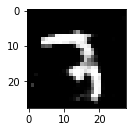

Epoch [112/200], Discriminator_loss 0.6799, Generator_Loss 0.7399
Epoch [112/200], Discriminator_loss 0.6934, Generator_Loss 0.9021
Epoch [112/200], Discriminator_loss 0.6817, Generator_Loss 0.7768
Epoch [112/200], Discriminator_loss 0.6792, Generator_Loss 0.8160
Epoch [112/200], Discriminator_loss 0.6701, Generator_Loss 0.8104
Epoch [112/200], Discriminator_loss 0.6281, Generator_Loss 0.7426


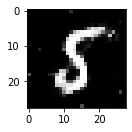

Epoch [113/200], Discriminator_loss 0.6785, Generator_Loss 0.7970
Epoch [113/200], Discriminator_loss 0.6663, Generator_Loss 0.7905
Epoch [113/200], Discriminator_loss 0.6628, Generator_Loss 0.7568
Epoch [113/200], Discriminator_loss 0.6757, Generator_Loss 0.8293
Epoch [113/200], Discriminator_loss 0.6643, Generator_Loss 0.7373
Epoch [113/200], Discriminator_loss 0.6635, Generator_Loss 0.7676


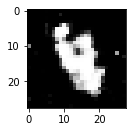

Epoch [114/200], Discriminator_loss 0.6643, Generator_Loss 0.8504
Epoch [114/200], Discriminator_loss 0.6382, Generator_Loss 0.8120
Epoch [114/200], Discriminator_loss 0.6421, Generator_Loss 0.7788
Epoch [114/200], Discriminator_loss 0.6757, Generator_Loss 0.7856
Epoch [114/200], Discriminator_loss 0.6674, Generator_Loss 0.7764
Epoch [114/200], Discriminator_loss 0.6688, Generator_Loss 0.8079


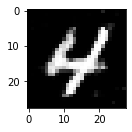

Epoch [115/200], Discriminator_loss 0.6558, Generator_Loss 0.7230
Epoch [115/200], Discriminator_loss 0.6750, Generator_Loss 0.7606
Epoch [115/200], Discriminator_loss 0.6845, Generator_Loss 0.7886
Epoch [115/200], Discriminator_loss 0.6826, Generator_Loss 0.8336
Epoch [115/200], Discriminator_loss 0.6325, Generator_Loss 0.7856
Epoch [115/200], Discriminator_loss 0.6809, Generator_Loss 0.8182


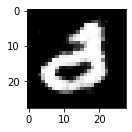

Epoch [116/200], Discriminator_loss 0.6527, Generator_Loss 0.7959
Epoch [116/200], Discriminator_loss 0.6528, Generator_Loss 0.7995
Epoch [116/200], Discriminator_loss 0.6847, Generator_Loss 0.7412
Epoch [116/200], Discriminator_loss 0.6526, Generator_Loss 0.7565
Epoch [116/200], Discriminator_loss 0.6534, Generator_Loss 0.8094
Epoch [116/200], Discriminator_loss 0.6588, Generator_Loss 0.7845


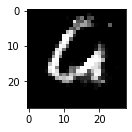

Epoch [117/200], Discriminator_loss 0.6617, Generator_Loss 0.8423
Epoch [117/200], Discriminator_loss 0.6787, Generator_Loss 0.8275
Epoch [117/200], Discriminator_loss 0.6470, Generator_Loss 0.8087
Epoch [117/200], Discriminator_loss 0.6688, Generator_Loss 0.7563
Epoch [117/200], Discriminator_loss 0.6423, Generator_Loss 0.7896
Epoch [117/200], Discriminator_loss 0.6563, Generator_Loss 0.8080


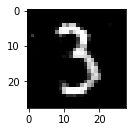

Epoch [118/200], Discriminator_loss 0.6786, Generator_Loss 0.7309
Epoch [118/200], Discriminator_loss 0.6812, Generator_Loss 0.7816
Epoch [118/200], Discriminator_loss 0.6644, Generator_Loss 0.8081
Epoch [118/200], Discriminator_loss 0.6477, Generator_Loss 0.7962
Epoch [118/200], Discriminator_loss 0.6414, Generator_Loss 0.7725
Epoch [118/200], Discriminator_loss 0.6586, Generator_Loss 0.7958


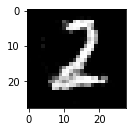

Epoch [119/200], Discriminator_loss 0.6720, Generator_Loss 0.7845
Epoch [119/200], Discriminator_loss 0.6354, Generator_Loss 0.7719
Epoch [119/200], Discriminator_loss 0.6642, Generator_Loss 0.8140
Epoch [119/200], Discriminator_loss 0.6442, Generator_Loss 0.7539
Epoch [119/200], Discriminator_loss 0.6449, Generator_Loss 0.7725
Epoch [119/200], Discriminator_loss 0.6686, Generator_Loss 0.8011


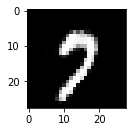

Epoch [120/200], Discriminator_loss 0.6765, Generator_Loss 0.7829
Epoch [120/200], Discriminator_loss 0.6592, Generator_Loss 0.6824
Epoch [120/200], Discriminator_loss 0.6714, Generator_Loss 0.7664
Epoch [120/200], Discriminator_loss 0.6818, Generator_Loss 0.7704
Epoch [120/200], Discriminator_loss 0.6660, Generator_Loss 0.8293
Epoch [120/200], Discriminator_loss 0.6693, Generator_Loss 0.7920


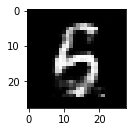

Epoch [121/200], Discriminator_loss 0.6645, Generator_Loss 0.8108
Epoch [121/200], Discriminator_loss 0.6611, Generator_Loss 0.8652
Epoch [121/200], Discriminator_loss 0.6709, Generator_Loss 0.7464
Epoch [121/200], Discriminator_loss 0.6698, Generator_Loss 0.8289
Epoch [121/200], Discriminator_loss 0.6802, Generator_Loss 0.7998
Epoch [121/200], Discriminator_loss 0.6370, Generator_Loss 0.8110


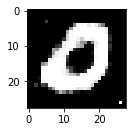

Epoch [122/200], Discriminator_loss 0.6598, Generator_Loss 0.8329
Epoch [122/200], Discriminator_loss 0.6840, Generator_Loss 0.8529
Epoch [122/200], Discriminator_loss 0.6501, Generator_Loss 0.8237
Epoch [122/200], Discriminator_loss 0.6595, Generator_Loss 0.8027
Epoch [122/200], Discriminator_loss 0.6615, Generator_Loss 0.8207
Epoch [122/200], Discriminator_loss 0.6658, Generator_Loss 0.7315


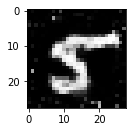

Epoch [123/200], Discriminator_loss 0.6713, Generator_Loss 0.7677
Epoch [123/200], Discriminator_loss 0.6791, Generator_Loss 0.6952
Epoch [123/200], Discriminator_loss 0.6827, Generator_Loss 0.7678
Epoch [123/200], Discriminator_loss 0.6539, Generator_Loss 0.7373
Epoch [123/200], Discriminator_loss 0.6447, Generator_Loss 0.7654
Epoch [123/200], Discriminator_loss 0.6560, Generator_Loss 0.7659


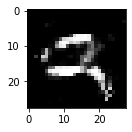

Epoch [124/200], Discriminator_loss 0.6644, Generator_Loss 0.7796
Epoch [124/200], Discriminator_loss 0.6583, Generator_Loss 0.7930
Epoch [124/200], Discriminator_loss 0.6366, Generator_Loss 0.8735
Epoch [124/200], Discriminator_loss 0.6827, Generator_Loss 0.8107
Epoch [124/200], Discriminator_loss 0.6398, Generator_Loss 0.7630
Epoch [124/200], Discriminator_loss 0.6667, Generator_Loss 0.8196


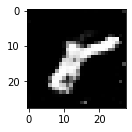

Epoch [125/200], Discriminator_loss 0.7043, Generator_Loss 0.7982
Epoch [125/200], Discriminator_loss 0.6928, Generator_Loss 0.7798
Epoch [125/200], Discriminator_loss 0.6817, Generator_Loss 0.7568
Epoch [125/200], Discriminator_loss 0.6668, Generator_Loss 0.7528
Epoch [125/200], Discriminator_loss 0.6728, Generator_Loss 0.8044
Epoch [125/200], Discriminator_loss 0.6676, Generator_Loss 0.8516


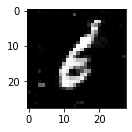

Epoch [126/200], Discriminator_loss 0.6754, Generator_Loss 0.7663
Epoch [126/200], Discriminator_loss 0.7097, Generator_Loss 0.8235
Epoch [126/200], Discriminator_loss 0.6608, Generator_Loss 0.7613
Epoch [126/200], Discriminator_loss 0.6518, Generator_Loss 0.7608
Epoch [126/200], Discriminator_loss 0.6424, Generator_Loss 0.6723
Epoch [126/200], Discriminator_loss 0.6424, Generator_Loss 0.8335


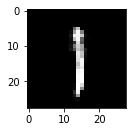

Epoch [127/200], Discriminator_loss 0.6334, Generator_Loss 0.8791
Epoch [127/200], Discriminator_loss 0.6211, Generator_Loss 0.8219
Epoch [127/200], Discriminator_loss 0.6675, Generator_Loss 0.8178
Epoch [127/200], Discriminator_loss 0.6636, Generator_Loss 0.7873
Epoch [127/200], Discriminator_loss 0.6864, Generator_Loss 0.8756
Epoch [127/200], Discriminator_loss 0.7032, Generator_Loss 0.8102


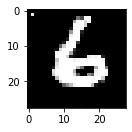

Epoch [128/200], Discriminator_loss 0.6917, Generator_Loss 0.7536
Epoch [128/200], Discriminator_loss 0.6565, Generator_Loss 0.8036
Epoch [128/200], Discriminator_loss 0.6740, Generator_Loss 0.8095
Epoch [128/200], Discriminator_loss 0.6649, Generator_Loss 0.8380
Epoch [128/200], Discriminator_loss 0.6972, Generator_Loss 0.7647
Epoch [128/200], Discriminator_loss 0.6746, Generator_Loss 0.7765


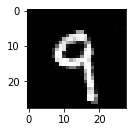

Epoch [129/200], Discriminator_loss 0.6708, Generator_Loss 0.8386
Epoch [129/200], Discriminator_loss 0.6706, Generator_Loss 0.8058
Epoch [129/200], Discriminator_loss 0.6693, Generator_Loss 0.7667
Epoch [129/200], Discriminator_loss 0.7000, Generator_Loss 0.7273
Epoch [129/200], Discriminator_loss 0.6552, Generator_Loss 0.7288
Epoch [129/200], Discriminator_loss 0.6727, Generator_Loss 0.8342


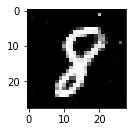

Epoch [130/200], Discriminator_loss 0.6794, Generator_Loss 0.7611
Epoch [130/200], Discriminator_loss 0.7095, Generator_Loss 0.7532
Epoch [130/200], Discriminator_loss 0.6507, Generator_Loss 0.7466
Epoch [130/200], Discriminator_loss 0.6595, Generator_Loss 0.7453
Epoch [130/200], Discriminator_loss 0.6357, Generator_Loss 0.7818
Epoch [130/200], Discriminator_loss 0.6547, Generator_Loss 0.7764


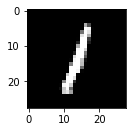

Epoch [131/200], Discriminator_loss 0.6574, Generator_Loss 0.7808
Epoch [131/200], Discriminator_loss 0.6518, Generator_Loss 0.7800
Epoch [131/200], Discriminator_loss 0.6642, Generator_Loss 0.8482
Epoch [131/200], Discriminator_loss 0.6525, Generator_Loss 0.7272
Epoch [131/200], Discriminator_loss 0.6496, Generator_Loss 0.7007
Epoch [131/200], Discriminator_loss 0.6592, Generator_Loss 0.7341


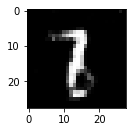

Epoch [132/200], Discriminator_loss 0.6644, Generator_Loss 0.7208
Epoch [132/200], Discriminator_loss 0.6348, Generator_Loss 0.8316
Epoch [132/200], Discriminator_loss 0.6624, Generator_Loss 0.7704
Epoch [132/200], Discriminator_loss 0.6678, Generator_Loss 0.7657
Epoch [132/200], Discriminator_loss 0.6239, Generator_Loss 0.7729
Epoch [132/200], Discriminator_loss 0.6680, Generator_Loss 0.7709


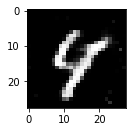

Epoch [133/200], Discriminator_loss 0.6742, Generator_Loss 0.7943
Epoch [133/200], Discriminator_loss 0.6278, Generator_Loss 0.7996
Epoch [133/200], Discriminator_loss 0.6573, Generator_Loss 0.7482
Epoch [133/200], Discriminator_loss 0.6424, Generator_Loss 0.7819
Epoch [133/200], Discriminator_loss 0.6498, Generator_Loss 0.7951
Epoch [133/200], Discriminator_loss 0.6426, Generator_Loss 0.7606


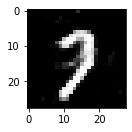

Epoch [134/200], Discriminator_loss 0.6477, Generator_Loss 0.8023
Epoch [134/200], Discriminator_loss 0.6515, Generator_Loss 0.7930
Epoch [134/200], Discriminator_loss 0.6697, Generator_Loss 0.7845
Epoch [134/200], Discriminator_loss 0.6454, Generator_Loss 0.7577
Epoch [134/200], Discriminator_loss 0.6894, Generator_Loss 0.8202
Epoch [134/200], Discriminator_loss 0.6750, Generator_Loss 0.7870


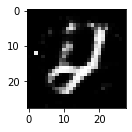

Epoch [135/200], Discriminator_loss 0.6522, Generator_Loss 0.8173
Epoch [135/200], Discriminator_loss 0.6896, Generator_Loss 0.7848
Epoch [135/200], Discriminator_loss 0.6922, Generator_Loss 0.7686
Epoch [135/200], Discriminator_loss 0.6593, Generator_Loss 0.8268
Epoch [135/200], Discriminator_loss 0.6360, Generator_Loss 0.7906
Epoch [135/200], Discriminator_loss 0.6380, Generator_Loss 0.7811


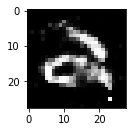

Epoch [136/200], Discriminator_loss 0.6626, Generator_Loss 0.7169
Epoch [136/200], Discriminator_loss 0.6463, Generator_Loss 0.7696
Epoch [136/200], Discriminator_loss 0.6640, Generator_Loss 0.7444
Epoch [136/200], Discriminator_loss 0.6365, Generator_Loss 0.7624
Epoch [136/200], Discriminator_loss 0.6407, Generator_Loss 0.8354
Epoch [136/200], Discriminator_loss 0.6613, Generator_Loss 0.7567


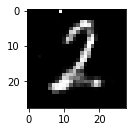

Epoch [137/200], Discriminator_loss 0.6356, Generator_Loss 0.7824
Epoch [137/200], Discriminator_loss 0.6733, Generator_Loss 0.8274
Epoch [137/200], Discriminator_loss 0.6645, Generator_Loss 0.8383
Epoch [137/200], Discriminator_loss 0.6637, Generator_Loss 0.7979
Epoch [137/200], Discriminator_loss 0.6616, Generator_Loss 0.7705
Epoch [137/200], Discriminator_loss 0.6524, Generator_Loss 0.7763


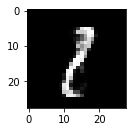

Epoch [138/200], Discriminator_loss 0.6695, Generator_Loss 0.8206
Epoch [138/200], Discriminator_loss 0.6879, Generator_Loss 0.7686
Epoch [138/200], Discriminator_loss 0.7026, Generator_Loss 0.7743
Epoch [138/200], Discriminator_loss 0.6660, Generator_Loss 0.8065
Epoch [138/200], Discriminator_loss 0.6684, Generator_Loss 0.8104
Epoch [138/200], Discriminator_loss 0.6296, Generator_Loss 0.8489


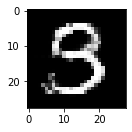

Epoch [139/200], Discriminator_loss 0.6442, Generator_Loss 0.7942
Epoch [139/200], Discriminator_loss 0.6501, Generator_Loss 0.8265
Epoch [139/200], Discriminator_loss 0.6902, Generator_Loss 0.8170
Epoch [139/200], Discriminator_loss 0.6907, Generator_Loss 0.7329
Epoch [139/200], Discriminator_loss 0.6434, Generator_Loss 0.7883
Epoch [139/200], Discriminator_loss 0.6980, Generator_Loss 0.8096


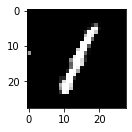

Epoch [140/200], Discriminator_loss 0.6624, Generator_Loss 0.7771
Epoch [140/200], Discriminator_loss 0.6658, Generator_Loss 0.8235
Epoch [140/200], Discriminator_loss 0.7064, Generator_Loss 0.7720
Epoch [140/200], Discriminator_loss 0.6726, Generator_Loss 0.8046
Epoch [140/200], Discriminator_loss 0.6460, Generator_Loss 0.7653
Epoch [140/200], Discriminator_loss 0.6737, Generator_Loss 0.9020


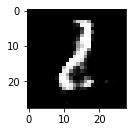

Epoch [141/200], Discriminator_loss 0.6644, Generator_Loss 0.7562
Epoch [141/200], Discriminator_loss 0.6529, Generator_Loss 0.7820
Epoch [141/200], Discriminator_loss 0.6793, Generator_Loss 0.7868
Epoch [141/200], Discriminator_loss 0.6371, Generator_Loss 0.7835
Epoch [141/200], Discriminator_loss 0.6802, Generator_Loss 0.7499
Epoch [141/200], Discriminator_loss 0.6483, Generator_Loss 0.8293


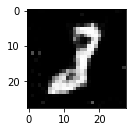

Epoch [142/200], Discriminator_loss 0.6666, Generator_Loss 0.7862
Epoch [142/200], Discriminator_loss 0.6270, Generator_Loss 0.7653
Epoch [142/200], Discriminator_loss 0.6526, Generator_Loss 0.7452
Epoch [142/200], Discriminator_loss 0.6663, Generator_Loss 0.8127
Epoch [142/200], Discriminator_loss 0.6405, Generator_Loss 0.6963
Epoch [142/200], Discriminator_loss 0.6511, Generator_Loss 0.7765


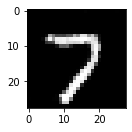

Epoch [143/200], Discriminator_loss 0.6658, Generator_Loss 0.6967
Epoch [143/200], Discriminator_loss 0.6307, Generator_Loss 0.7929
Epoch [143/200], Discriminator_loss 0.6615, Generator_Loss 0.7553
Epoch [143/200], Discriminator_loss 0.7194, Generator_Loss 0.8239
Epoch [143/200], Discriminator_loss 0.6617, Generator_Loss 0.7993
Epoch [143/200], Discriminator_loss 0.7035, Generator_Loss 0.7879


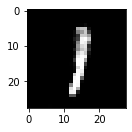

Epoch [144/200], Discriminator_loss 0.6691, Generator_Loss 0.7042
Epoch [144/200], Discriminator_loss 0.6604, Generator_Loss 0.8031
Epoch [144/200], Discriminator_loss 0.6468, Generator_Loss 0.8148
Epoch [144/200], Discriminator_loss 0.6649, Generator_Loss 0.7681
Epoch [144/200], Discriminator_loss 0.6644, Generator_Loss 0.7553
Epoch [144/200], Discriminator_loss 0.6744, Generator_Loss 0.7841


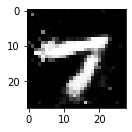

Epoch [145/200], Discriminator_loss 0.6713, Generator_Loss 0.7263
Epoch [145/200], Discriminator_loss 0.6673, Generator_Loss 0.7871
Epoch [145/200], Discriminator_loss 0.6605, Generator_Loss 0.8712
Epoch [145/200], Discriminator_loss 0.6531, Generator_Loss 0.7772
Epoch [145/200], Discriminator_loss 0.6205, Generator_Loss 0.8442
Epoch [145/200], Discriminator_loss 0.6801, Generator_Loss 0.7605


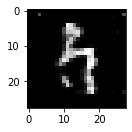

Epoch [146/200], Discriminator_loss 0.6549, Generator_Loss 0.7821
Epoch [146/200], Discriminator_loss 0.6430, Generator_Loss 0.8576
Epoch [146/200], Discriminator_loss 0.6831, Generator_Loss 0.7997
Epoch [146/200], Discriminator_loss 0.6332, Generator_Loss 0.7780
Epoch [146/200], Discriminator_loss 0.6515, Generator_Loss 0.8860
Epoch [146/200], Discriminator_loss 0.6476, Generator_Loss 0.8155


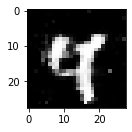

Epoch [147/200], Discriminator_loss 0.6513, Generator_Loss 0.8265
Epoch [147/200], Discriminator_loss 0.6797, Generator_Loss 0.7684
Epoch [147/200], Discriminator_loss 0.6362, Generator_Loss 0.7981
Epoch [147/200], Discriminator_loss 0.6559, Generator_Loss 0.8194
Epoch [147/200], Discriminator_loss 0.6825, Generator_Loss 0.8317
Epoch [147/200], Discriminator_loss 0.6575, Generator_Loss 0.7675


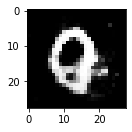

Epoch [148/200], Discriminator_loss 0.6976, Generator_Loss 0.8491
Epoch [148/200], Discriminator_loss 0.6486, Generator_Loss 0.7050
Epoch [148/200], Discriminator_loss 0.6764, Generator_Loss 0.7981
Epoch [148/200], Discriminator_loss 0.6742, Generator_Loss 0.7855
Epoch [148/200], Discriminator_loss 0.6569, Generator_Loss 0.7566
Epoch [148/200], Discriminator_loss 0.6628, Generator_Loss 0.8278


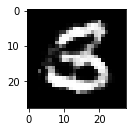

Epoch [149/200], Discriminator_loss 0.6859, Generator_Loss 0.7942
Epoch [149/200], Discriminator_loss 0.6650, Generator_Loss 0.7325
Epoch [149/200], Discriminator_loss 0.6461, Generator_Loss 0.8152
Epoch [149/200], Discriminator_loss 0.6724, Generator_Loss 0.7726
Epoch [149/200], Discriminator_loss 0.6970, Generator_Loss 0.7457
Epoch [149/200], Discriminator_loss 0.7121, Generator_Loss 0.7291


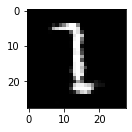

Epoch [150/200], Discriminator_loss 0.6973, Generator_Loss 0.7495
Epoch [150/200], Discriminator_loss 0.6580, Generator_Loss 0.7861
Epoch [150/200], Discriminator_loss 0.6774, Generator_Loss 0.7581
Epoch [150/200], Discriminator_loss 0.6714, Generator_Loss 0.8254
Epoch [150/200], Discriminator_loss 0.6461, Generator_Loss 0.7621
Epoch [150/200], Discriminator_loss 0.6370, Generator_Loss 0.7833


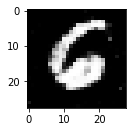

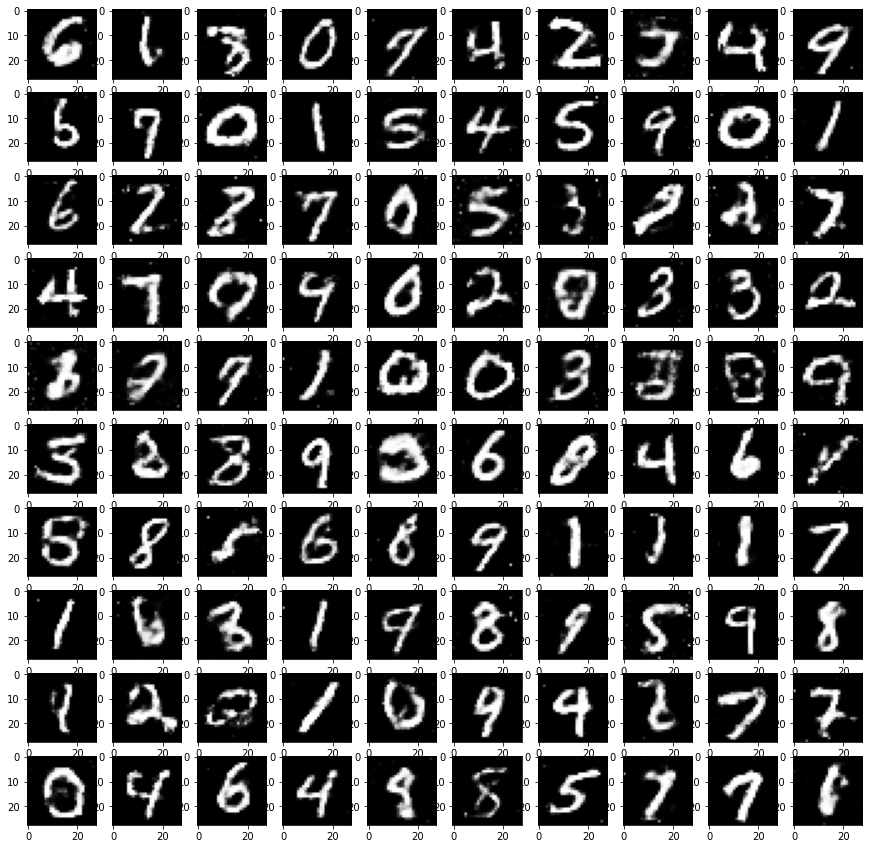

Epoch [151/200], Discriminator_loss 0.6686, Generator_Loss 0.8134
Epoch [151/200], Discriminator_loss 0.6465, Generator_Loss 0.8061
Epoch [151/200], Discriminator_loss 0.6496, Generator_Loss 0.7528
Epoch [151/200], Discriminator_loss 0.6679, Generator_Loss 0.8335
Epoch [151/200], Discriminator_loss 0.6620, Generator_Loss 0.7396
Epoch [151/200], Discriminator_loss 0.6690, Generator_Loss 0.8531


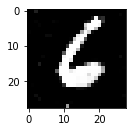

Epoch [152/200], Discriminator_loss 0.6352, Generator_Loss 0.7704
Epoch [152/200], Discriminator_loss 0.6297, Generator_Loss 0.7476
Epoch [152/200], Discriminator_loss 0.6558, Generator_Loss 0.7367
Epoch [152/200], Discriminator_loss 0.6751, Generator_Loss 0.7827
Epoch [152/200], Discriminator_loss 0.6616, Generator_Loss 0.8225
Epoch [152/200], Discriminator_loss 0.6955, Generator_Loss 0.8096


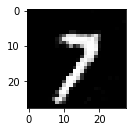

Epoch [153/200], Discriminator_loss 0.6957, Generator_Loss 0.7338
Epoch [153/200], Discriminator_loss 0.6833, Generator_Loss 0.7665
Epoch [153/200], Discriminator_loss 0.6745, Generator_Loss 0.7636
Epoch [153/200], Discriminator_loss 0.6841, Generator_Loss 0.9071
Epoch [153/200], Discriminator_loss 0.6661, Generator_Loss 0.7871
Epoch [153/200], Discriminator_loss 0.6629, Generator_Loss 0.8094


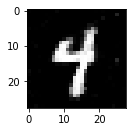

Epoch [154/200], Discriminator_loss 0.6602, Generator_Loss 0.7941
Epoch [154/200], Discriminator_loss 0.6681, Generator_Loss 0.8049
Epoch [154/200], Discriminator_loss 0.7049, Generator_Loss 0.8240
Epoch [154/200], Discriminator_loss 0.6815, Generator_Loss 0.8787
Epoch [154/200], Discriminator_loss 0.6511, Generator_Loss 0.7454
Epoch [154/200], Discriminator_loss 0.6622, Generator_Loss 0.7452


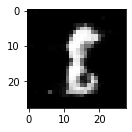

Epoch [155/200], Discriminator_loss 0.6579, Generator_Loss 0.8042
Epoch [155/200], Discriminator_loss 0.6532, Generator_Loss 0.8040
Epoch [155/200], Discriminator_loss 0.6665, Generator_Loss 0.7236
Epoch [155/200], Discriminator_loss 0.6644, Generator_Loss 0.8920
Epoch [155/200], Discriminator_loss 0.6816, Generator_Loss 0.7942
Epoch [155/200], Discriminator_loss 0.6696, Generator_Loss 0.7688


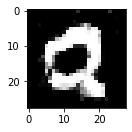

Epoch [156/200], Discriminator_loss 0.6780, Generator_Loss 0.7204
Epoch [156/200], Discriminator_loss 0.6666, Generator_Loss 0.7758
Epoch [156/200], Discriminator_loss 0.6525, Generator_Loss 0.8298
Epoch [156/200], Discriminator_loss 0.6702, Generator_Loss 0.7542
Epoch [156/200], Discriminator_loss 0.6796, Generator_Loss 0.7447
Epoch [156/200], Discriminator_loss 0.6710, Generator_Loss 0.7306


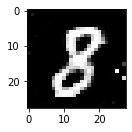

Epoch [157/200], Discriminator_loss 0.6828, Generator_Loss 0.7668
Epoch [157/200], Discriminator_loss 0.6341, Generator_Loss 0.7845
Epoch [157/200], Discriminator_loss 0.6804, Generator_Loss 0.7958
Epoch [157/200], Discriminator_loss 0.6694, Generator_Loss 0.7941
Epoch [157/200], Discriminator_loss 0.6434, Generator_Loss 0.7958
Epoch [157/200], Discriminator_loss 0.6520, Generator_Loss 0.7466


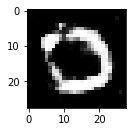

Epoch [158/200], Discriminator_loss 0.6787, Generator_Loss 0.7936
Epoch [158/200], Discriminator_loss 0.6515, Generator_Loss 0.7895
Epoch [158/200], Discriminator_loss 0.6454, Generator_Loss 0.7862
Epoch [158/200], Discriminator_loss 0.6434, Generator_Loss 0.7453
Epoch [158/200], Discriminator_loss 0.6719, Generator_Loss 0.8067
Epoch [158/200], Discriminator_loss 0.6656, Generator_Loss 0.7664


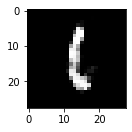

Epoch [159/200], Discriminator_loss 0.6524, Generator_Loss 0.7642
Epoch [159/200], Discriminator_loss 0.6792, Generator_Loss 0.7716
Epoch [159/200], Discriminator_loss 0.6516, Generator_Loss 0.8060
Epoch [159/200], Discriminator_loss 0.6624, Generator_Loss 0.7996
Epoch [159/200], Discriminator_loss 0.6675, Generator_Loss 0.8290
Epoch [159/200], Discriminator_loss 0.6779, Generator_Loss 0.8428


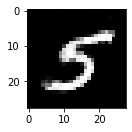

Epoch [160/200], Discriminator_loss 0.6407, Generator_Loss 0.8033
Epoch [160/200], Discriminator_loss 0.6780, Generator_Loss 0.8015
Epoch [160/200], Discriminator_loss 0.6470, Generator_Loss 0.8244
Epoch [160/200], Discriminator_loss 0.6601, Generator_Loss 0.7380
Epoch [160/200], Discriminator_loss 0.6480, Generator_Loss 0.7820
Epoch [160/200], Discriminator_loss 0.6605, Generator_Loss 0.7696


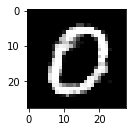

Epoch [161/200], Discriminator_loss 0.6645, Generator_Loss 0.7625
Epoch [161/200], Discriminator_loss 0.6627, Generator_Loss 0.7788
Epoch [161/200], Discriminator_loss 0.6455, Generator_Loss 0.7820
Epoch [161/200], Discriminator_loss 0.6882, Generator_Loss 0.7992
Epoch [161/200], Discriminator_loss 0.6642, Generator_Loss 0.8368
Epoch [161/200], Discriminator_loss 0.6551, Generator_Loss 0.7959


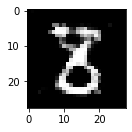

Epoch [162/200], Discriminator_loss 0.6627, Generator_Loss 0.8234
Epoch [162/200], Discriminator_loss 0.6692, Generator_Loss 0.7565
Epoch [162/200], Discriminator_loss 0.6515, Generator_Loss 0.7877
Epoch [162/200], Discriminator_loss 0.6650, Generator_Loss 0.6941
Epoch [162/200], Discriminator_loss 0.6588, Generator_Loss 0.7767
Epoch [162/200], Discriminator_loss 0.6740, Generator_Loss 0.8090


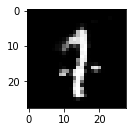

Epoch [163/200], Discriminator_loss 0.6594, Generator_Loss 0.7908
Epoch [163/200], Discriminator_loss 0.6963, Generator_Loss 0.7688
Epoch [163/200], Discriminator_loss 0.6707, Generator_Loss 0.7799
Epoch [163/200], Discriminator_loss 0.6752, Generator_Loss 0.7994
Epoch [163/200], Discriminator_loss 0.6529, Generator_Loss 0.7542
Epoch [163/200], Discriminator_loss 0.6552, Generator_Loss 0.7237


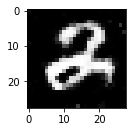

Epoch [164/200], Discriminator_loss 0.6774, Generator_Loss 0.7785
Epoch [164/200], Discriminator_loss 0.6557, Generator_Loss 0.8133
Epoch [164/200], Discriminator_loss 0.6631, Generator_Loss 0.8022
Epoch [164/200], Discriminator_loss 0.6631, Generator_Loss 0.7694
Epoch [164/200], Discriminator_loss 0.6779, Generator_Loss 0.7536
Epoch [164/200], Discriminator_loss 0.6517, Generator_Loss 0.7565


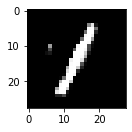

Epoch [165/200], Discriminator_loss 0.6444, Generator_Loss 0.8203
Epoch [165/200], Discriminator_loss 0.6828, Generator_Loss 0.7383
Epoch [165/200], Discriminator_loss 0.6986, Generator_Loss 0.7410
Epoch [165/200], Discriminator_loss 0.6673, Generator_Loss 0.8079
Epoch [165/200], Discriminator_loss 0.6848, Generator_Loss 0.8050
Epoch [165/200], Discriminator_loss 0.6671, Generator_Loss 0.8109


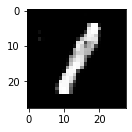

Epoch [166/200], Discriminator_loss 0.6464, Generator_Loss 0.8053
Epoch [166/200], Discriminator_loss 0.6479, Generator_Loss 0.7477
Epoch [166/200], Discriminator_loss 0.6627, Generator_Loss 0.8026
Epoch [166/200], Discriminator_loss 0.6079, Generator_Loss 0.7792
Epoch [166/200], Discriminator_loss 0.6743, Generator_Loss 0.7852
Epoch [166/200], Discriminator_loss 0.6626, Generator_Loss 0.7709


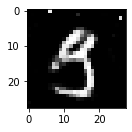

Epoch [167/200], Discriminator_loss 0.6455, Generator_Loss 0.8100
Epoch [167/200], Discriminator_loss 0.6591, Generator_Loss 0.8300
Epoch [167/200], Discriminator_loss 0.6419, Generator_Loss 0.8509
Epoch [167/200], Discriminator_loss 0.6565, Generator_Loss 0.9213
Epoch [167/200], Discriminator_loss 0.6682, Generator_Loss 0.7585
Epoch [167/200], Discriminator_loss 0.6761, Generator_Loss 0.8349


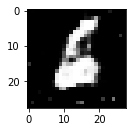

Epoch [168/200], Discriminator_loss 0.6744, Generator_Loss 0.8027
Epoch [168/200], Discriminator_loss 0.6538, Generator_Loss 0.8070
Epoch [168/200], Discriminator_loss 0.6419, Generator_Loss 0.8119
Epoch [168/200], Discriminator_loss 0.6618, Generator_Loss 0.7963
Epoch [168/200], Discriminator_loss 0.6873, Generator_Loss 0.8103
Epoch [168/200], Discriminator_loss 0.6529, Generator_Loss 0.8093


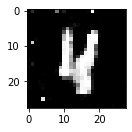

Epoch [169/200], Discriminator_loss 0.6802, Generator_Loss 0.8196
Epoch [169/200], Discriminator_loss 0.6901, Generator_Loss 0.8223
Epoch [169/200], Discriminator_loss 0.6441, Generator_Loss 0.7809
Epoch [169/200], Discriminator_loss 0.6690, Generator_Loss 0.8056
Epoch [169/200], Discriminator_loss 0.6429, Generator_Loss 0.8243
Epoch [169/200], Discriminator_loss 0.6933, Generator_Loss 0.7581


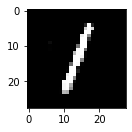

Epoch [170/200], Discriminator_loss 0.6532, Generator_Loss 0.6740
Epoch [170/200], Discriminator_loss 0.6519, Generator_Loss 0.7859
Epoch [170/200], Discriminator_loss 0.6833, Generator_Loss 0.8027
Epoch [170/200], Discriminator_loss 0.6715, Generator_Loss 0.8507
Epoch [170/200], Discriminator_loss 0.6511, Generator_Loss 0.8113
Epoch [170/200], Discriminator_loss 0.6846, Generator_Loss 0.8003


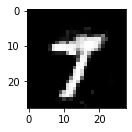

Epoch [171/200], Discriminator_loss 0.6507, Generator_Loss 0.7762
Epoch [171/200], Discriminator_loss 0.6569, Generator_Loss 0.8273
Epoch [171/200], Discriminator_loss 0.6588, Generator_Loss 0.8179
Epoch [171/200], Discriminator_loss 0.6515, Generator_Loss 0.7789
Epoch [171/200], Discriminator_loss 0.6591, Generator_Loss 0.7510
Epoch [171/200], Discriminator_loss 0.6791, Generator_Loss 0.8209


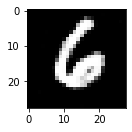

Epoch [172/200], Discriminator_loss 0.6704, Generator_Loss 0.7494
Epoch [172/200], Discriminator_loss 0.6754, Generator_Loss 0.7439
Epoch [172/200], Discriminator_loss 0.6493, Generator_Loss 0.7925
Epoch [172/200], Discriminator_loss 0.6755, Generator_Loss 0.8472
Epoch [172/200], Discriminator_loss 0.6522, Generator_Loss 0.7800
Epoch [172/200], Discriminator_loss 0.6632, Generator_Loss 0.7742


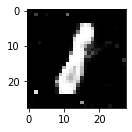

Epoch [173/200], Discriminator_loss 0.6680, Generator_Loss 0.7872
Epoch [173/200], Discriminator_loss 0.7033, Generator_Loss 0.8064
Epoch [173/200], Discriminator_loss 0.6382, Generator_Loss 0.7699
Epoch [173/200], Discriminator_loss 0.6878, Generator_Loss 0.7382
Epoch [173/200], Discriminator_loss 0.6638, Generator_Loss 0.8569
Epoch [173/200], Discriminator_loss 0.6741, Generator_Loss 0.7787


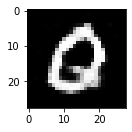

Epoch [174/200], Discriminator_loss 0.6603, Generator_Loss 0.7353
Epoch [174/200], Discriminator_loss 0.6643, Generator_Loss 0.7933
Epoch [174/200], Discriminator_loss 0.6543, Generator_Loss 0.7228
Epoch [174/200], Discriminator_loss 0.6822, Generator_Loss 0.8222
Epoch [174/200], Discriminator_loss 0.6591, Generator_Loss 0.7083
Epoch [174/200], Discriminator_loss 0.6289, Generator_Loss 0.7929


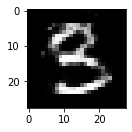

Epoch [175/200], Discriminator_loss 0.6548, Generator_Loss 0.7753
Epoch [175/200], Discriminator_loss 0.6574, Generator_Loss 0.8138
Epoch [175/200], Discriminator_loss 0.6945, Generator_Loss 0.7732
Epoch [175/200], Discriminator_loss 0.6453, Generator_Loss 0.7948
Epoch [175/200], Discriminator_loss 0.6330, Generator_Loss 0.7903
Epoch [175/200], Discriminator_loss 0.6644, Generator_Loss 0.8561


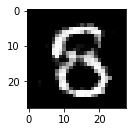

Epoch [176/200], Discriminator_loss 0.6517, Generator_Loss 0.7576
Epoch [176/200], Discriminator_loss 0.6811, Generator_Loss 0.8062
Epoch [176/200], Discriminator_loss 0.6904, Generator_Loss 0.9042
Epoch [176/200], Discriminator_loss 0.6499, Generator_Loss 0.8194
Epoch [176/200], Discriminator_loss 0.6545, Generator_Loss 0.8554
Epoch [176/200], Discriminator_loss 0.6460, Generator_Loss 0.8100


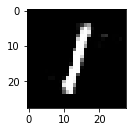

Epoch [177/200], Discriminator_loss 0.6532, Generator_Loss 0.8387
Epoch [177/200], Discriminator_loss 0.6669, Generator_Loss 0.8096
Epoch [177/200], Discriminator_loss 0.6625, Generator_Loss 0.7955
Epoch [177/200], Discriminator_loss 0.6726, Generator_Loss 0.8153
Epoch [177/200], Discriminator_loss 0.6562, Generator_Loss 0.7268
Epoch [177/200], Discriminator_loss 0.6731, Generator_Loss 0.7510


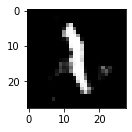

Epoch [178/200], Discriminator_loss 0.6770, Generator_Loss 0.8365
Epoch [178/200], Discriminator_loss 0.6551, Generator_Loss 0.8298
Epoch [178/200], Discriminator_loss 0.6270, Generator_Loss 0.7849
Epoch [178/200], Discriminator_loss 0.6597, Generator_Loss 0.8288
Epoch [178/200], Discriminator_loss 0.6705, Generator_Loss 0.7529
Epoch [178/200], Discriminator_loss 0.6601, Generator_Loss 0.9363


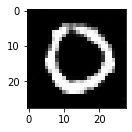

Epoch [179/200], Discriminator_loss 0.6790, Generator_Loss 0.7667
Epoch [179/200], Discriminator_loss 0.6245, Generator_Loss 0.7937
Epoch [179/200], Discriminator_loss 0.7111, Generator_Loss 0.7778
Epoch [179/200], Discriminator_loss 0.6435, Generator_Loss 0.7686
Epoch [179/200], Discriminator_loss 0.6595, Generator_Loss 0.7686
Epoch [179/200], Discriminator_loss 0.6603, Generator_Loss 0.8513


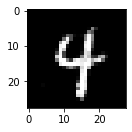

Epoch [180/200], Discriminator_loss 0.6281, Generator_Loss 0.8386
Epoch [180/200], Discriminator_loss 0.6537, Generator_Loss 0.7737
Epoch [180/200], Discriminator_loss 0.6920, Generator_Loss 0.7710
Epoch [180/200], Discriminator_loss 0.6356, Generator_Loss 0.7993
Epoch [180/200], Discriminator_loss 0.6635, Generator_Loss 0.8410
Epoch [180/200], Discriminator_loss 0.6522, Generator_Loss 0.7972


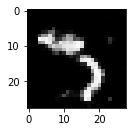

Epoch [181/200], Discriminator_loss 0.6809, Generator_Loss 0.7218
Epoch [181/200], Discriminator_loss 0.6552, Generator_Loss 0.8157
Epoch [181/200], Discriminator_loss 0.6526, Generator_Loss 0.7926
Epoch [181/200], Discriminator_loss 0.6624, Generator_Loss 0.8234
Epoch [181/200], Discriminator_loss 0.6398, Generator_Loss 0.7992
Epoch [181/200], Discriminator_loss 0.6392, Generator_Loss 0.8144


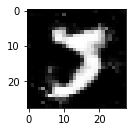

Epoch [182/200], Discriminator_loss 0.6841, Generator_Loss 0.7692
Epoch [182/200], Discriminator_loss 0.6807, Generator_Loss 0.7813
Epoch [182/200], Discriminator_loss 0.6441, Generator_Loss 0.8051
Epoch [182/200], Discriminator_loss 0.6556, Generator_Loss 0.8029
Epoch [182/200], Discriminator_loss 0.6648, Generator_Loss 0.8134
Epoch [182/200], Discriminator_loss 0.6643, Generator_Loss 0.8365


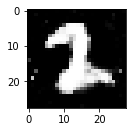

Epoch [183/200], Discriminator_loss 0.6651, Generator_Loss 0.8147
Epoch [183/200], Discriminator_loss 0.6474, Generator_Loss 0.7456
Epoch [183/200], Discriminator_loss 0.6457, Generator_Loss 0.8240
Epoch [183/200], Discriminator_loss 0.6866, Generator_Loss 0.7345
Epoch [183/200], Discriminator_loss 0.6677, Generator_Loss 0.7465
Epoch [183/200], Discriminator_loss 0.6404, Generator_Loss 0.7810


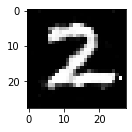

Epoch [184/200], Discriminator_loss 0.6431, Generator_Loss 0.8278
Epoch [184/200], Discriminator_loss 0.6581, Generator_Loss 0.7592
Epoch [184/200], Discriminator_loss 0.6866, Generator_Loss 0.7718
Epoch [184/200], Discriminator_loss 0.6615, Generator_Loss 0.8073
Epoch [184/200], Discriminator_loss 0.6591, Generator_Loss 0.8447
Epoch [184/200], Discriminator_loss 0.6567, Generator_Loss 0.8110


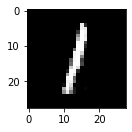

Epoch [185/200], Discriminator_loss 0.6435, Generator_Loss 0.8007
Epoch [185/200], Discriminator_loss 0.6445, Generator_Loss 0.8080
Epoch [185/200], Discriminator_loss 0.6700, Generator_Loss 0.8413
Epoch [185/200], Discriminator_loss 0.6821, Generator_Loss 0.7846
Epoch [185/200], Discriminator_loss 0.7067, Generator_Loss 0.7868
Epoch [185/200], Discriminator_loss 0.6573, Generator_Loss 0.8509


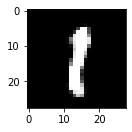

Epoch [186/200], Discriminator_loss 0.6695, Generator_Loss 0.8141
Epoch [186/200], Discriminator_loss 0.6496, Generator_Loss 0.7852
Epoch [186/200], Discriminator_loss 0.6323, Generator_Loss 0.7785
Epoch [186/200], Discriminator_loss 0.6732, Generator_Loss 0.8415
Epoch [186/200], Discriminator_loss 0.6552, Generator_Loss 0.8042
Epoch [186/200], Discriminator_loss 0.6493, Generator_Loss 0.7913


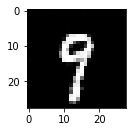

Epoch [187/200], Discriminator_loss 0.6906, Generator_Loss 0.8596
Epoch [187/200], Discriminator_loss 0.6422, Generator_Loss 0.7816
Epoch [187/200], Discriminator_loss 0.6748, Generator_Loss 0.7976
Epoch [187/200], Discriminator_loss 0.6578, Generator_Loss 0.7423
Epoch [187/200], Discriminator_loss 0.6578, Generator_Loss 0.8238
Epoch [187/200], Discriminator_loss 0.6461, Generator_Loss 0.8315


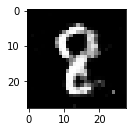

Epoch [188/200], Discriminator_loss 0.6850, Generator_Loss 0.8121
Epoch [188/200], Discriminator_loss 0.6417, Generator_Loss 0.8029
Epoch [188/200], Discriminator_loss 0.6542, Generator_Loss 0.8110
Epoch [188/200], Discriminator_loss 0.6685, Generator_Loss 0.7473
Epoch [188/200], Discriminator_loss 0.6570, Generator_Loss 0.7831
Epoch [188/200], Discriminator_loss 0.6412, Generator_Loss 0.8095


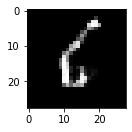

Epoch [189/200], Discriminator_loss 0.6823, Generator_Loss 0.7638
Epoch [189/200], Discriminator_loss 0.6698, Generator_Loss 0.8140
Epoch [189/200], Discriminator_loss 0.6811, Generator_Loss 0.8090
Epoch [189/200], Discriminator_loss 0.6406, Generator_Loss 0.8773
Epoch [189/200], Discriminator_loss 0.6525, Generator_Loss 0.8281
Epoch [189/200], Discriminator_loss 0.6726, Generator_Loss 0.8747


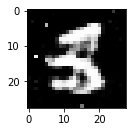

Epoch [190/200], Discriminator_loss 0.6660, Generator_Loss 0.8216
Epoch [190/200], Discriminator_loss 0.6507, Generator_Loss 0.8280
Epoch [190/200], Discriminator_loss 0.6596, Generator_Loss 0.7576
Epoch [190/200], Discriminator_loss 0.6207, Generator_Loss 0.7829
Epoch [190/200], Discriminator_loss 0.6691, Generator_Loss 0.8274
Epoch [190/200], Discriminator_loss 0.6621, Generator_Loss 0.8536


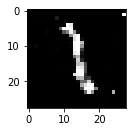

Epoch [191/200], Discriminator_loss 0.6517, Generator_Loss 0.8115
Epoch [191/200], Discriminator_loss 0.6572, Generator_Loss 0.7952
Epoch [191/200], Discriminator_loss 0.7064, Generator_Loss 0.7921
Epoch [191/200], Discriminator_loss 0.6483, Generator_Loss 0.7412
Epoch [191/200], Discriminator_loss 0.6545, Generator_Loss 0.8012
Epoch [191/200], Discriminator_loss 0.6719, Generator_Loss 0.8075


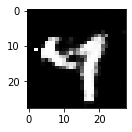

Epoch [192/200], Discriminator_loss 0.6579, Generator_Loss 0.8706
Epoch [192/200], Discriminator_loss 0.6446, Generator_Loss 0.8009
Epoch [192/200], Discriminator_loss 0.6765, Generator_Loss 0.7616
Epoch [192/200], Discriminator_loss 0.6512, Generator_Loss 0.8133
Epoch [192/200], Discriminator_loss 0.6429, Generator_Loss 0.7833
Epoch [192/200], Discriminator_loss 0.6374, Generator_Loss 0.8097


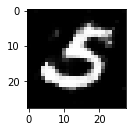

Epoch [193/200], Discriminator_loss 0.6434, Generator_Loss 0.8216
Epoch [193/200], Discriminator_loss 0.6559, Generator_Loss 0.8289
Epoch [193/200], Discriminator_loss 0.6686, Generator_Loss 0.7696
Epoch [193/200], Discriminator_loss 0.6705, Generator_Loss 0.7568
Epoch [193/200], Discriminator_loss 0.6869, Generator_Loss 0.8301
Epoch [193/200], Discriminator_loss 0.6663, Generator_Loss 0.8224


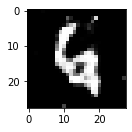

Epoch [194/200], Discriminator_loss 0.6653, Generator_Loss 0.8141
Epoch [194/200], Discriminator_loss 0.6639, Generator_Loss 0.6600
Epoch [194/200], Discriminator_loss 0.6665, Generator_Loss 0.7835
Epoch [194/200], Discriminator_loss 0.6599, Generator_Loss 0.8089
Epoch [194/200], Discriminator_loss 0.6430, Generator_Loss 0.7677
Epoch [194/200], Discriminator_loss 0.6599, Generator_Loss 0.7946


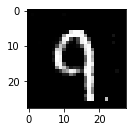

Epoch [195/200], Discriminator_loss 0.6528, Generator_Loss 0.7169
Epoch [195/200], Discriminator_loss 0.6531, Generator_Loss 0.8239
Epoch [195/200], Discriminator_loss 0.6586, Generator_Loss 0.7309
Epoch [195/200], Discriminator_loss 0.6898, Generator_Loss 0.7706
Epoch [195/200], Discriminator_loss 0.6456, Generator_Loss 0.6970
Epoch [195/200], Discriminator_loss 0.6557, Generator_Loss 0.8074


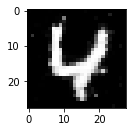

Epoch [196/200], Discriminator_loss 0.6438, Generator_Loss 0.8182
Epoch [196/200], Discriminator_loss 0.6616, Generator_Loss 0.8174
Epoch [196/200], Discriminator_loss 0.6529, Generator_Loss 0.8196
Epoch [196/200], Discriminator_loss 0.6422, Generator_Loss 0.7693
Epoch [196/200], Discriminator_loss 0.6508, Generator_Loss 0.8084
Epoch [196/200], Discriminator_loss 0.6867, Generator_Loss 0.8122


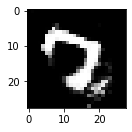

Epoch [197/200], Discriminator_loss 0.6443, Generator_Loss 0.7564
Epoch [197/200], Discriminator_loss 0.6657, Generator_Loss 0.7974
Epoch [197/200], Discriminator_loss 0.6502, Generator_Loss 0.7832
Epoch [197/200], Discriminator_loss 0.6671, Generator_Loss 0.7136
Epoch [197/200], Discriminator_loss 0.6688, Generator_Loss 0.7795
Epoch [197/200], Discriminator_loss 0.6675, Generator_Loss 0.8371


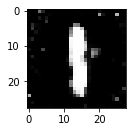

Epoch [198/200], Discriminator_loss 0.6411, Generator_Loss 0.7762
Epoch [198/200], Discriminator_loss 0.6999, Generator_Loss 0.8100
Epoch [198/200], Discriminator_loss 0.6537, Generator_Loss 0.7735
Epoch [198/200], Discriminator_loss 0.6412, Generator_Loss 0.8409
Epoch [198/200], Discriminator_loss 0.6499, Generator_Loss 0.8013
Epoch [198/200], Discriminator_loss 0.6596, Generator_Loss 0.8238


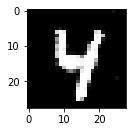

Epoch [199/200], Discriminator_loss 0.6767, Generator_Loss 0.8546
Epoch [199/200], Discriminator_loss 0.6732, Generator_Loss 0.7905
Epoch [199/200], Discriminator_loss 0.6519, Generator_Loss 0.7562
Epoch [199/200], Discriminator_loss 0.6744, Generator_Loss 0.7581
Epoch [199/200], Discriminator_loss 0.6369, Generator_Loss 0.7558
Epoch [199/200], Discriminator_loss 0.6275, Generator_Loss 0.7403


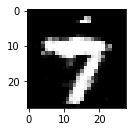

Epoch [200/200], Discriminator_loss 0.6712, Generator_Loss 0.8032
Epoch [200/200], Discriminator_loss 0.6488, Generator_Loss 0.8139
Epoch [200/200], Discriminator_loss 0.6587, Generator_Loss 0.8077
Epoch [200/200], Discriminator_loss 0.6824, Generator_Loss 0.8176
Epoch [200/200], Discriminator_loss 0.6870, Generator_Loss 0.8270
Epoch [200/200], Discriminator_loss 0.6888, Generator_Loss 0.8306


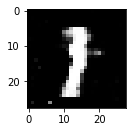

200 epochs of training the GAN is completed


In [ ]:
track_file=1
epochs = 200
for epoch in range(epochs):
    epoch=epoch+1

    for looping_counter, data in enumerate(train_loader):
        looping_counter=looping_counter+1

        real_images = data[0].to(device)
        real_images, label_real = real_images.view(-1, mnist_img_dim), torch.ones(real_images.shape[0], 1).to(device)

        noise_vector =((torch.rand(real_images.shape[0], 128) -0.5) / 0.5).to(device)

        fake_images = G(noise_vector)
        output_real, output_fake = D(real_images), D(fake_images)
        
        label_fake=torch.zeros(fake_images.shape[0], 1).to(device)

        # Here we concate both the real images, and fake images also real labels, and fake labels to pass to discriminator
     
       
        tot_outputs, tot_labels = torch.cat((output_real, output_fake), 0), torch.cat((label_real, label_fake),0)

        discriminator_optimizer.zero_grad()
        discriminator_loss = loss_function(tot_outputs, tot_labels)
        discriminator_loss.backward()
        discriminator_optimizer.step()

        noise_vector =((torch.rand(real_images.shape[0], 128) -0.5) / 0.5).to(device)

        
#        f = open('latent_files2/latent_files{}.txt'.format(epoch), 'w')

#        latent_string=str(noise_vector)
#        f.write(latent_string)
#        f.close()

        fake_images = G(noise_vector)
        output_fake = D(fake_images)
        tot_labels = torch.ones([output_fake.shape[0],1]).to(device)

        generator_loss = loss_function(output_fake, tot_labels)
        generator_optimizer.zero_grad()
        generator_loss.backward()
        generator_optimizer.step()

        if looping_counter % 100 == 0 :
            print ('Epoch [{}/{}], Discriminator_loss {:.4f}, Generator_Loss {:.4f}'.format(epoch, epochs, discriminator_loss.item(), generator_loss.item()))

    imgs_numpy = (fake_images.data.cpu().numpy()+1.0)/2.0
    for index, image in enumerate(imgs_numpy[:1]):
        plt.subplot(2, 2, index+1)
        plt.imshow(image.reshape(28,28), cmap='gray')
    plt.show()
    # print grid of 10 x 10 at epoch 150
    if(epoch==150):
      figure = plt.figure(figsize=(15,15))
      for index, image in enumerate(imgs_numpy[:100]):
        plt.subplot(10, 10, index+1)
        plt.imshow(image.reshape(28,28), cmap='gray')
      plt.show()

# saving the state of the generator in a pickle file
Pkl_G = "G.pkl"  
with open(Pkl_G, 'wb') as file:  
    pickle.dump(G, file)
# saving the state of the discriminator in a pickle file    
Pkl_D = "D.pkl"  
with open(Pkl_D, 'wb') as file:  
    pickle.dump(D, file)

print("200 epochs of training the GAN is completed")

In [ ]:
!zip -r ./MNISTtest_data.zip ./MNISTtest_data/

  adding: MNISTtest_data/ (stored 0%)
  adding: MNISTtest_data/image32.png (stored 0%)
  adding: MNISTtest_data/image79.png (stored 0%)
  adding: MNISTtest_data/image25.png (stored 0%)
  adding: MNISTtest_data/image38.png (stored 0%)
  adding: MNISTtest_data/image59.png (stored 0%)
  adding: MNISTtest_data/image73.png (stored 0%)
  adding: MNISTtest_data/image75.png (stored 0%)
  adding: MNISTtest_data/image51.png (stored 0%)
  adding: MNISTtest_data/image37.png (stored 0%)
  adding: MNISTtest_data/image39.png (stored 0%)
  adding: MNISTtest_data/image62.png (stored 0%)
  adding: MNISTtest_data/image17.png (stored 0%)
  adding: MNISTtest_data/image94.png (stored 0%)
  adding: MNISTtest_data/image30.png (stored 0%)
  adding: MNISTtest_data/image72.png (stored 0%)
  adding: MNISTtest_data/image97.png (stored 0%)
  adding: MNISTtest_data/image55.png (stored 0%)
  adding: MNISTtest_data/image80.png (stored 0%)
  adding: MNISTtest_data/image83.png (stored 0%)
  adding: MNISTtest_data/image7

In [ ]:
from google.colab import files
files.download("MNISTtest_data.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!zip -r ./latent_files.zip ./latent_files/

  adding: latent_files/ (stored 0%)
  adding: latent_files/latent_files161.txt (deflated 54%)
  adding: latent_files/latent_files82.txt (deflated 55%)
  adding: latent_files/latent_files199.txt (deflated 55%)
  adding: latent_files/latent_files10.txt (deflated 54%)
  adding: latent_files/latent_files174.txt (deflated 55%)
  adding: latent_files/latent_files29.txt (deflated 54%)
  adding: latent_files/latent_files153.txt (deflated 55%)
  adding: latent_files/latent_files14.txt (deflated 55%)
  adding: latent_files/latent_files20.txt (deflated 55%)
  adding: latent_files/latent_files89.txt (deflated 55%)
  adding: latent_files/latent_files59.txt (deflated 55%)
  adding: latent_files/latent_files90.txt (deflated 54%)
  adding: latent_files/latent_files149.txt (deflated 54%)
  adding: latent_files/latent_files50.txt (deflated 54%)
  adding: latent_files/latent_files26.txt (deflated 55%)
  adding: latent_files/latent_files176.txt (deflated 55%)
  adding: latent_files/latent_files169.txt (de

In [ ]:
from google.colab import files
files.download("latent_files.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!zip -r ./latent_files2.zip ./latent_files2/

  adding: latent_files2/ (stored 0%)
  adding: latent_files2/latent_files82.txt (deflated 55%)
  adding: latent_files2/latent_files10.txt (deflated 55%)
  adding: latent_files2/latent_files29.txt (deflated 54%)
  adding: latent_files2/latent_files14.txt (deflated 55%)
  adding: latent_files2/latent_files20.txt (deflated 55%)
  adding: latent_files2/latent_files89.txt (deflated 54%)
  adding: latent_files2/latent_files59.txt (deflated 55%)
  adding: latent_files2/latent_files90.txt (deflated 56%)
  adding: latent_files2/latent_files50.txt (deflated 55%)
  adding: latent_files2/latent_files26.txt (deflated 55%)
  adding: latent_files2/latent_files78.txt (deflated 54%)
  adding: latent_files2/latent_files56.txt (deflated 54%)
  adding: latent_files2/latent_files99.txt (deflated 54%)
  adding: latent_files2/latent_files93.txt (deflated 54%)
  adding: latent_files2/latent_files73.txt (deflated 54%)
  adding: latent_files2/latent_files22.txt (deflated 54%)
  adding: latent_files2/latent_file

In [ ]:
from google.colab import files
files.download("latent_files2.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=36,  #16          
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(36, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization


In [ ]:
cnn=CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 36, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(36, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [ ]:
cnn_loss_func = nn.CrossEntropyLoss()
cnn_loss_func

CrossEntropyLoss()

In [ ]:
cnn_optimizer = optim.Adam(cnn.parameters(), lr=0.01)
cnn_optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

In [ ]:
print(len(train_loader))

600


In [ ]:
print(len(test_loader))

100


### Now using <b> CNN as the classifier for entire MNIST dataset </b>


In [ ]:
num_epochs = 100

#Remember to run on GPU

def train(num_epochs, cnn, loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(train_loader)
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]  
 #           print(images.size())       
            loss = cnn_loss_func(output, b_y)
            
            # clear gradients for this training step   
            cnn_optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            cnn_optimizer.step()                
            
           
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                pass
        pass
    pass

train(num_epochs, cnn, train_loader)

Pkl_C = "C.pkl"  
with open(Pkl_C, 'wb') as file:  
    pickle.dump(cnn, file)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/100], Step [100/600], Loss: 0.1197
Epoch [1/100], Step [200/600], Loss: 0.0630
Epoch [1/100], Step [300/600], Loss: 0.1000
Epoch [1/100], Step [400/600], Loss: 0.0282
Epoch [1/100], Step [500/600], Loss: 0.0684
Epoch [1/100], Step [600/600], Loss: 0.0598
Epoch [2/100], Step [100/600], Loss: 0.0717
Epoch [2/100], Step [200/600], Loss: 0.0779
Epoch [2/100], Step [300/600], Loss: 0.1417
Epoch [2/100], Step [400/600], Loss: 0.2068
Epoch [2/100], Step [500/600], Loss: 0.1109
Epoch [2/100], Step [600/600], Loss: 0.0585
Epoch [3/100], Step [100/600], Loss: 0.0527
Epoch [3/100], Step [200/600], Loss: 0.1015
Epoch [3/100], Step [300/600], Loss: 0.0361
Epoch [3/100], Step [400/600], Loss: 0.0373
Epoch [3/100], Step [500/600], Loss: 0.1478
Epoch [3/100], Step [600/600], Loss: 0.0784
Epoch [4/100], Step [100/600], Loss: 0.1739
Epoch [4/100], Step [200/600], Loss: 0.1515
Epoch [4/100], Step [300/600], Loss: 0.1009
Epoch [4/100], Step [400/600], Loss: 0.0968
Epoch [4/100], Step [500/600], L

In [ ]:
def test():
  count=0
  cnn.eval()
  with torch.no_grad():
    correct=0
    total=0
    for images, labels in test_loader:
        while(count<20):
          count=count+1
#          print(count,"this is the count")
          test_output,last_layer=cnn(images)
          pred_y=torch.max(test_output,1)[1].data.squeeze()
          accuracy=(pred_y==labels).sum().item()/float(labels.size(0))
          pass
    print('Test Acc %.2f' % accuracy)
    pass


test()

Test Acc 0.99


### Now using <b> CNN as the classifier for S0 dataset </b>


### I import the batch_size as 1, to take one element at a time

In [ ]:
from torch.utils.data import DataLoader
train_S0=DataLoader(train_data, batch_size=10, shuffle=True)
test_S0=DataLoader(test_data, batch_size=10, shuffle=False)

### Here I take the entire trainset which has 60,000 data points, the train_loader has 600, means multiplied by 100(batch_size) we get 60,000 datapoints, 100 epoch consider with a  batch_size of only 1, even from there i only need 80 datapoints, so i introduce a count, which takes in only 80 datapoints , so this 80 train datapoints, plus 20 test datapoints forms 100 datapoints of MNIST dataset, <b>this is S0 dataset</b> sir asked to make in assignment

In [ ]:
num_epochs = 100

#Remember to run on GPU

def train(num_epochs, cnn, loaders):
    
    cnn.train()

    count=0    
    # Train the model
    total_step = len(train_S0)

#   while(num_epochs<100):
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_S0):
 #       for images,labels in (train_S0):
        #for epoch in range(num_epochs):
          
            while(count<80): 
       # for i, (images, labels) in enumerate(loaders['train']):
                count=count+1
#                print(count,"this is the count")
            # gives batch data, normalize x when iterate train_loader
                b_x = Variable(images)   # batch x
                b_y = Variable(labels)   # batch y
#               print(images.size())
                output = cnn(b_x)[0]               
                loss = cnn_loss_func(output, b_y)
 #               print(loss.item())
            
            # clear gradients for this training step   
                cnn_optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
                loss.backward() 
                print("The Loss", end =" ")  
                print(loss.item())
            # apply gradients             
                cnn_optimizer.step()                
 
        if (i+1) % 100 == 0:
 #           print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
            print (' Loss: {:.4f}'.format( loss.item()))
            pass
        pass
    pass


train(num_epochs , cnn, train_loader)

The Loss 2.8505330085754395
The Loss 2.8502581119537354
The Loss 2.8466176986694336
The Loss 2.8401408195495605
The Loss 2.8312954902648926
The Loss 2.8204922676086426
The Loss 2.8080906867980957
The Loss 2.794400691986084
The Loss 2.7796921730041504
The Loss 2.764193534851074
The Loss 2.7481040954589844
The Loss 2.7315917015075684
The Loss 2.7148003578186035
The Loss 2.697850227355957
The Loss 2.6808438301086426
The Loss 2.6638669967651367
The Loss 2.64699125289917
The Loss 2.6302759647369385
The Loss 2.6137688159942627
The Loss 2.597510814666748
The Loss 2.581533908843994
The Loss 2.5658624172210693
The Loss 2.5505175590515137
The Loss 2.535513162612915
The Loss 2.520862102508545
The Loss 2.506570339202881
The Loss 2.4926443099975586
The Loss 2.4790852069854736
The Loss 2.465893507003784
The Loss 2.453068971633911
The Loss 2.440608263015747
The Loss 2.4285073280334473
The Loss 2.416761875152588
The Loss 2.4053664207458496
The Loss 2.3943142890930176
The Loss 2.383598804473877
The Los

KeyboardInterrupt: ignored

##### <b> The accuracy of classifier on S0 dataset is</b>

###### Here I take the entire testset which has 10,000 data points, the train_loader has 100, means multiplied by 100(batch_size) we get 10,000 datapoints, 100 epoch consider with a  batch_size of only 1, even from there i only need 20 datapoints, so i introduce a count, which takes in only 20 datapoints , so  80 train datapoints from above, plus this 20 test datapoints forms 100 datapoints of MNIST dataset, <b>this is S0 dataset</b> sir asked to make in assignment

In [ ]:
def test():
  count=0
  cnn.eval()
  with torch.no_grad():
    correct=0
    total=0
    for images, labels in test_loader:
        while(count<20):
          count=count+1
#          print(count,"this is the count")
          test_output,last_layer=cnn(images)
          pred_y=torch.max(test_output,1)[1].data.squeeze()
          accuracy=(pred_y==labels).sum().item()/float(labels.size(0))
          pass
    print('Test Acc %.2f' % accuracy)
    pass


test()

Test Acc 0.96


In [ ]:
from google.colab import files
uploaded =files.upload()

Saving Generated_fake_digits.zip to Generated_fake_digits.zip


In [ ]:
!unzip Generated_fake_digits.zip

Archive:  Generated_fake_digits.zip
   creating: Generated_fake_digits/
  inflating: Generated_fake_digits/index30.png  
  inflating: Generated_fake_digits/index31.png  
  inflating: Generated_fake_digits/index32.png  
  inflating: Generated_fake_digits/index33.png  
  inflating: Generated_fake_digits/index34.png  
  inflating: Generated_fake_digits/index35.png  
  inflating: Generated_fake_digits/index36.png  
  inflating: Generated_fake_digits/index39.png  
  inflating: Generated_fake_digits/index41.png  
  inflating: Generated_fake_digits/index42.png  
  inflating: Generated_fake_digits/index44.png  
  inflating: Generated_fake_digits/index45.png  
  inflating: Generated_fake_digits/index46.png  
  inflating: Generated_fake_digits/index47.png  
  inflating: Generated_fake_digits/index48.png  
  inflating: Generated_fake_digits/index50.png  
  inflating: Generated_fake_digits/index52.png  
  inflating: Generated_fake_digits/index53.png  
  inflating: Generated_fake_digits/index54.png

In [ ]:
from PIL import Image
from torchvision import transforms

In [ ]:
!mkdir new_FakeDigit

In [ ]:
numpy_img_arrays = np.array([])

In [ ]:
import os
directory = 'Generated_fake_digits'

for filename in os.listdir(directory):
  f = os.path.join(directory, filename)
  img = Image.open(f)
  p = transforms.Compose([transforms.Scale((28,28))])
  new_img=p(img)
  numpy_img = np.array(new_img)
  numpy_img_arrays = np.append(numpy_img_arrays, numpy_img)
 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:310: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=4,  #16          
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(4, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
 #       self.out = nn.Linear(32 * 7 * 7, 10)
        self.out = nn.Linear(32, 4)

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        print(x.shape)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization


In [ ]:
cnn_me=CNN()
print(cnn_me)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(4, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=32, out_features=1, bias=True)
)


In [ ]:
img = Image.open('Generated_fake_digits/index0.png')
img.size

(132, 132)

In [ ]:
compres = transforms.Compose([transforms.Scale((5,5))])
compres(img).size

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:310: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


(5, 5)

In [ ]:
transform_to_tensor =transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

In [ ]:
final_img=compres(transform_to_tensor(img))

In [ ]:
final_img.size()

torch.Size([4, 5, 5])

In [ ]:

final_img = final_img.view(-1, 1,5,5)

In [ ]:
final_img.size()

torch.Size([4, 1, 5, 5])

In [ ]:
import numpy as np
label_data = np.array([1])
label1 = torch.tensor(label_data)

In [ ]:
label1.size()

torch.Size([1])

In [ ]:
num_epochs = 1

#Remember to run on GPU

def train(num_epochs, cnn):
    
    cnn.train()

    count=0    
    # Train the model
#    total_step = len(train_loader)

    while(num_epochs==1):
#        for images,labels in (train_loader):
        #for epoch in range(num_epochs):
          
            while(count<1): 
       # for i, (images, labels) in enumerate(loaders['train']):
                count=count+1
#                print(count,"this is the count")
            # gives batch data, normalize x when iterate train_loader
                b_x = Variable(final_img)   # batch x
                b_y = Variable(label1)   # batch y
                output = cnn_me(b_x)[0]               
                loss = cnn_loss_func(output, b_y)
            
            # clear gradients for this training step   
                cnn_optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
                loss.backward()    
            # apply gradients             
                cnn_optimizer.step()                
            
     #       if (i+1) % 100 == 0:
     #           print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
     #           pass
#        pass
    pass


train(1, cnn)

torch.Size([4, 32, 1, 1])


ValueError: ignored